# Adaptive PDE discretizations on Cartesian grids
## Volume : Divergence form PDEs
## Part : Linear elasticity
## Chapter : Gradient backpropagation in anisotropic acoustic and elastic waves

$
\newcommand\bbone{\mathbb 1}\newcommand\sm{\setminus}
\newcommand\<{\langle}\newcommand\>{\rangle}
\newcommand\vp{\varphi}
\newcommand\diff{\mathrm d}\newcommand\Diff{\mathrm{D}}
\DeclareMathOperator\Id{Id}\DeclareMathOperator\len{len}\DeclareMathOperator\Tr{Tr}
\newcommand\kF{\mathfrak F}
\newcommand\cL{\mathcal L}\newcommand\cF{\mathcal F}\newcommand\cO{\mathcal O}\newcommand\cS{\mathcal S} 
\newcommand\cE{\mathcal E} 
\newcommand\cD{\mathcal D}
\newcommand\bQ{\mathbb Q}\newcommand\bR{\mathbb R}\newcommand\bS{\mathbb S}\newcommand\bZ{\mathbb Z}
\newcommand\ve{\varepsilon}
\newcommand\kg{\mathrm{kg}}
\newcommand\diver{\mathrm{div}}\newcommand\kw{\mathrm{k}}
\newcommand\damp{\mathrm{damp}}
$

In this notebook, we run numerical instances of the acoustic and elastic wave equation, with absorbing boundary conditions.

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Models construction](#1.-Models-construction)
    * [1.1 Damping layer](#1.1-Damping-layer)
    * [1.2 A complex synthetic medium](#1.2-A-complex-synthetic-medium)
    * [1.3 Medium differentiation](#1.3-Medium-differentiation)
  * [2. Acoustic wave equation](#2.-Acoustic-wave-equation)
    * [2.1 Homogeneous example](#2.1-Homogeneous-example)
    * [2.2 Complex medium](#2.2-Complex-medium)
  * [3 Automatic differentiation of seismograms](#3-Automatic-differentiation-of-seismograms)
    * [3.1 Forward differentiation](#3.1-Forward-differentiation)
    * [3.2 Reverse differentiation](#3.2-Reverse-differentiation)
    * [3.3 Sensitivity to variations in the whole domain](#3.3-Sensitivity-to-variations-in-the-whole-domain)
  * [4. Elasticity](#4.-Elasticity)
    * [4.1 Homogeneous medium](#4.1-Homogeneous-medium)
    * [4.2 Complex medium](#4.2-Complex-medium)
    * [4.3 Forward differentiation](#4.3-Forward-differentiation)
    * [4.4 Reverse differentiation](#4.4-Reverse-differentiation)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('WaveExamples','Div'))

In [2]:
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import Domain
from agd.Metrics import Riemann
from agd.Metrics.Seismic import Hooke, Thomsen
from agd.ODE.hamiltonian import QuadraticHamiltonian
from agd import AutomaticDifferentiation as ad
from agd.Eikonal.HFM_CUDA import AnisotropicWave as aw
from agd.Interpolation import map_coordinates
from agd.Plotting import savefig,quiver,Tissot; #savefig.dirName = 'Images/ElasticityDirichlet'
norm = ad.Optimization.norm
mica,_ = Hooke.mica 
cupy_get = ad.cupy_generic.cupy_get # Turn a cupy array into a numpy array

In [3]:
import numpy as np; xp=np; allclose=np.allclose; π = np.pi
from matplotlib import pyplot as plt
from matplotlib.colors import AsinhNorm
from scipy import ndimage
from numpy.random import rand

### 0.1 Additional configuration

Uncomment the following line to use the gpu solvers

In [4]:
#xp,plt,quiver,mica,allclose,ndimage,quiver = map(ad.cupy_friendly,(xp,plt,quiver,mica,allclose,ndimage,quiver))

In [5]:
if xp is np: # Use CPU sparse matrix solvers
    AcousticHamiltonian = aw.AcousticHamiltonian_Sparse
    ElasticHamiltonian = aw.ElasticHamiltonian_Sparse
else: # Use GPU kernels
    AcousticHamiltonian = aw.AcousticHamiltonian_Kernel
    ElasticHamiltonian = aw.ElasticHamiltonian_Kernel
    Tissot = ad.cupy_generic.cupy_get_args(Tissot,iterables=(Riemann,)) # Allow GPU data

In [6]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global AcousticHamiltonian,ElasticHamiltonian,Hooke
    AcousticHamiltonian,ElasticHamiltonian,Hooke = rreload([
        AcousticHamiltonian,ElasticHamiltonian,Hooke],rootdir="../../AdaptiveGridDiscretizations")

In [7]:
def reload_packages2():
    from Miscellaneous.rreload import rreload
    global quiver,Selling,ad
    quiver,Selling,ad = rreload([quiver,Selling,ad],rootdir="../../AdaptiveGridDiscretizations")

### 0.2 Utility functions

The following functions are used for smooth transition layers in the models construction.

In [8]:
def heaviside(x):
    """Smoothed heaviside function, with a transition over [-1,1]"""
    # Primitives of (1-x^2)^k : x - x**3/3, x - (2*x**3)/3 + x**5/5, x - x**3 + (3*x**5)/5 - x**7/7
    def p(x): return x - (2*x**3)/3 + x**5/5
    return 0.5+0.5*np.where(x<=-1,-1,np.where(x>=1,1,p(x)/p(1)))
    
def bump(x,r,δ):
    """A bump over the interval [-r,r], with a transition over [r-δ,r+δ]"""
    return heaviside((r-np.abs(x))/δ)

The following functions are used to set initial conditions for the acoustic and elastic wave equations.

In [9]:
def make_domain(radius,vdim):
    """Produces the periodic domain [-radius,radius]^2, with 25 pixels per unit"""
    aX,dx = xp.linspace(-radius,radius,50*radius,endpoint=False,retstep=True)
    X=ad.array(np.meshgrid(*(aX,)*vdim,indexing='ij'))
    dom = Domain.MockDirichlet(X.shape[1:],dx,padding=None) #Periodic domain (wrap instead of pad)
    return dom,X,dx

def gaussian(X,σ=0.1,x0=None): 
    if x0 is not None: X = X - fd.as_field(x0,X.shape[1:],depth=1)
    return np.exp(-lp.dot_VV(X,X)/(2*σ**2)) # Non normalized gaussian with prescribed variance
def churp(X,*args,**kwargs):
    """
    Laplacian of Gaussian, often used as a source in acoustic wave equation.
    *args, **kwargs : passed to gaussian
    """
    vdim = len(X)
    X_ad = ad.Dense2.identity(constant=X,shape_free=(vdim,))
    g_ad = gaussian(X_ad,*args,**kwargs)
    return -sum(g_ad.hessian(i,i) for i in range(vdim))
def explosion(X,*args,**kwargs):
    """
    Triggers a pressure wave in all directions, emulating an explosion.
    *args, **kwargs : passed to gaussian
    """
    X_ad = ad.Dense.identity(constant=X,shape_free=(len(X),))
    return -gaussian(X_ad,*args,**kwargs).gradient()
def torsion(X,*args,**kwargs):
    """
    Triggers a torsion wave in all directions, using a torsion-like initial momentum (2D)
    *args, **kwargs : passed to gaussian
    """
    e0,e1 = explosion(X,*args,**kwargs) 
    return ad.array([-e1,e0]) # Perpendicular vector

The following functions are used to compute forward and backward differentiation of the wave equations.

In [10]:
def gram(x,y):
    assert x.ndim==y.ndim
    return np.sum(x[...,None,:]*y[...,:,None],axis=tuple(range(x.ndim-1)))
    
def fwd_grad(qf_fwd, pf_fwd, qh_fwd, ph_fwd,
             qf_grad,pf_grad,qh_grad,ph_grad):
    """Gradient of the objective functional obtained via forward AD"""
    return gram(qf_grad,qf_fwd.coef) + gram(pf_grad,pf_fwd.coef) + gram(qh_grad,qh_fwd.coef) + gram(ph_grad,ph_fwd.coef)

def rev_grad(q0_fwd, p0_fwd, H_fwd,
             q0_grad,p0_grad,H_rev):
    """Gradient of the objective functional obtained via reversed AD"""
    return gram(q0_grad,q0_fwd.coef) + gram(p0_grad,p0_fwd.coef) \
          + gram(H_rev.iρ.coef,H_fwd.iρ.coef) - gram(H_rev.weights.coef,H_fwd.weights.coef)

def sensitivity_to_ρ(H_rev): 
    return -(H_rev.iρ*H_rev.iρ.value**2).coef

def sensitivity_to_D(H_rev,offsets=None):
    """Assumes Selling/Voronoi decomposition"""
    from agd.Metrics import misc # import flatten_symmetric_matrix as fltsym
    if offsets is None:offsets = H_rev.offsets
    eet_flat = misc.flatten_symmetric_matrix(lp.outer_self(offsets)).astype(H_rev.weights.dtype)
    # Could be made more efficient and accurate, since the inverses are essentially known
    eet_mat = lp.transpose(eet_flat)[...,None]
    if not ad.cupy_generic.from_cupy(H_rev.weights.value): res = lp.solve_AV(eet_mat,H_rev.weights.coef) 
    else: # Cupy appears to have stricter broadcasting rules here
    	res = lp.solve_AV(np.broadcast_to(eet_mat,(*eet_mat.shape[:-1],H_rev.weights.size_ad)),H_rev.weights.coef)
    res = misc.expand_symmetric_matrix(res)/2 
    for i in range(len(res)): res[i,i]*=2 # Normalization accounts for duplication of off-diagonal coefficients
    return res

def sensitivity_to_M(H_rev): 
    return H_rev.M.coef
    
def sensitivity_to_C(H_rev):
    """Assumes Selling/Voronoi decomposition"""
    if hasattr(H_rev,'offsets'): return sensitivity_to_D(H_rev,H_rev.offsets)
    # If no offsets, we use the matrix offsets and take care of Voigt notation
    m = H_rev.moffsets 
    vdim = len(m)
    if vdim==1:   return sensitivity_to_D(H_rev,m[0])
    elif vdim==2: return sensitivity_to_D(H_rev,(m[0,0],m[1,1],m[0,1]))
    elif vdim==3: return sensitivity_to_D(H_rev,(m[0,0],m[1,1],m[2,2],m[1,2],m[0,2],m[0,1]))

The following cell implements some reproducibility checks.

In [11]:
def MakeRandomTensor(dim, shape=tuple(), relax=0.05):
    A = np.random.standard_normal( (dim,dim) + shape )
    D = lp.dot_AA(lp.transpose(A),A)
    identity = np.eye(dim).reshape((dim,dim)+(1,)*len(shape))
    return D+lp.trace(D)*relax*identity

def rand(*args): 
    return np.random.rand(*args)

def rand_ad(x,size_ad,sym=False):
    x_coef = rand(*x.shape,size_ad)
    if sym: x_coef = (x_coef+lp.transpose(x_coef))/2
    return ad.Dense.denseAD(x,x_coef)

def check_ad_rand(vdim,nX,wavetype,niter,size_fwd,size_rev):
    """Generate random parameters for check_ad"""
    np.random.seed(42)
    shape = (nX,)*vdim
    if wavetype=='Acoustic':
        ρ = 0.2+rand(*shape); ρ /= np.max(ρ)
        D = MakeRandomTensor(vdim,shape,0.2); D/=np.max(D)
	#	D[:] = np.eye(vdim).reshape((vdim,vdim)+(1,)*vdim); print("Alternative : D = Id")
        params = (ρ,D)
        q0,p0 = rand(*shape), rand(*shape)
    elif wavetype=='Elastic': 
#        ρ = 0.2+rand(*shape); ρ /= np.max(ρ); M = ρ[None,None]
        M = MakeRandomTensor(vdim,shape,0.3); M /= np.max(M)
        symdim = (vdim*(vdim+1))//2
        C = MakeRandomTensor(symdim,shape,0.2); C/=np.max(C)
        np.random.seed(54)
        q0,p0 = rand(vdim,*shape),rand(vdim,*shape)
#        M = np.ones_like(M); C*=0; q0*=0; p0*=0; p0[0]=1
        params = (M,C)
    else: raise ValueError("Unrecognized wave type")

    params_fwd = tuple(rand_ad(x,size_fwd,sym) for x,sym in zip(params,(wavetype=='Elastic',True)))
    q0_fwd = rand_ad(q0,size_fwd); p0_fwd = rand_ad(p0,size_fwd)

	# Using random.choice without replacement, otherwise fails.
    qh_ind = np.unravel_index(np.random.choice(q0.size,8,replace=False),q0.shape)
    ph_ind = np.unravel_index(np.random.choice(p0.size,7,replace=False),p0.shape)
    
    damp_p = rand(*shape); damp_q = rand(*shape)
    qf_grad = rand(*q0.shape,size_rev); pf_grad = rand(*p0.shape,size_rev)
    qh_grad = rand(niter-1,qh_ind[0].size,size_rev); ph_grad = rand(niter-1,ph_ind[0].size,size_rev)

    return params,params_fwd,q0,q0_fwd,p0,p0_fwd,qh_ind,ph_ind,damp_p,damp_q,qf_grad,pf_grad,qh_grad,ph_grad

def check_ad_run(wavetype,order_x,order_t,bc,niter,size_rev,data,implem):
    Hamiltonian = aw.WaveHamiltonian[(wavetype,implem)] 
    dt = 0.1
    dx = 1
    params,params_fwd,q0,q0_fwd,p0,p0_fwd,qh_ind,ph_ind,damp_p,damp_q,qf_grad,pf_grad,qh_grad,ph_grad = data
    tols={'atol':1e-6,'rtol':1e-6} if ad.cupy_generic.from_cupy(q0) else {}

    traits = {"traits":{'shape_i':(4,)*len(q0)}} if Hamiltonian is aw.ElasticHamiltonian_Kernel else {}
    H_fwd = Hamiltonian(*params_fwd,dx,bc=bc,order_x=order_x,save_weights=True,**traits)
    H_rev = Hamiltonian(*params    ,dx,bc=bc,order_x=order_x,save_weights=True,rev_ad=size_rev,**traits)

    H_fwd.damp_p = damp_p; H_fwd.damp_q = damp_q
    H_rev.damp_p = H_fwd.damp_p; H_rev.damp_q = H_fwd.damp_q
    
    qf_fwd,pf_fwd,qh_fwd,ph_fwd = H_fwd.seismogram(q0_fwd,p0_fwd,dt,niter,order_t,qh_ind=qh_ind,ph_ind=ph_ind)
    qf,pf,qh,ph,backprop = H_rev.seismogram_with_backprop(q0,p0,dt,niter,order_t,qh_ind=qh_ind,ph_ind=ph_ind)

    assert np.allclose(qf_fwd.value,qf,**tols)
    assert np.allclose(pf_fwd.value,pf,**tols)
    assert np.allclose(ad.remove_ad(qh_fwd),qh,**tols)
    assert np.allclose(ad.remove_ad(ph_fwd),ph,**tols)

    q0_grad,p0_grad = backprop(qf_grad=qf_grad,pf_grad=pf_grad,qh_grad=qh_grad,ph_grad=ph_grad)

    qh_fwd = ad.Dense.denseAD(qh_fwd); ph_fwd = ad.Dense.denseAD(ph_fwd) 
    grad1 = fwd_grad(qf_fwd, pf_fwd, qh_fwd, ph_fwd, qf_grad, pf_grad, qh_grad, ph_grad)
    grad2 = rev_grad(q0_fwd, p0_fwd, H_fwd, q0_grad, p0_grad, H_rev)
    #print("\n",grad1,"\n",grad2,"\n",grad2/grad1)
    assert allclose(grad1,grad2)

    if wavetype=='Acoustic':
        ρ_ξ = sensitivity_to_ρ(H_rev)
        D_ξ = sensitivity_to_D(H_rev)
        ρ_fwd,D_fwd = params_fwd
        assert np.allclose(gram(ρ_ξ,ρ_fwd.coef), gram(H_rev.iρ.coef,H_fwd.iρ.coef),**tols)
        assert np.allclose(gram(D_ξ,D_fwd.coef), gram(H_rev.weights.coef,H_fwd.weights.coef),**tols)
    elif wavetype=='Elastic':
        M_ξ = sensitivity_to_M(H_rev)
        C_ξ = sensitivity_to_C(H_rev)
        M_fwd,C_fwd = params_fwd
        assert np.allclose(gram(M_ξ,M_fwd.coef), gram(H_rev.M.coef,H_fwd.M.coef),**tols)
        assert np.allclose(gram(C_ξ,C_fwd.coef), gram(H_rev.weights.coef,H_fwd.weights.coef),**tols)

    return qf_fwd,pf_fwd,qh_fwd,ph_fwd,q0_grad,p0_grad

def check_ad(vdim,nX,wavetype,order_x=2,order_t=2,bc='Neumann',niter=4,size_fwd=2,size_rev=2):
    """
    - size_fwd : number of independent symbolic perturbations of the inputs
    - size_rev : number of objective functions at the target
    """
    if xp is not np and bc=='Neumann': bc='Periodic'
    print(f"Testing {vdim=}, {nX=}, {wavetype=}, {order_x=}, {order_t=}, {niter=}, {bc=}, {size_fwd=}, {size_rev=}, gpu={xp is not np}, ",end='')
    data = check_ad_rand(vdim,nX,wavetype,niter,size_fwd,size_rev) # Generate random parameters

    res_Sparse = check_ad_run(wavetype,order_x,order_t,bc,niter,size_rev,data,"Sparse")
    if xp is not np: # Also check the GPU implementation
        data = ad.cupy_generic.cupy_set(data,iterables=(tuple,))
        res_Kernel = check_ad_run(wavetype,order_x,order_t,bc,niter,size_rev,data,"Kernel")
        for x,y in zip(res_Sparse,res_Kernel): assert np.allclose(x,y,atol=1e-6,rtol=1e-6)
    print("passed.")

def some_check_ad():
    check_ad(1,10,'Acoustic')
    check_ad(2,7,'Acoustic',order_t=4,bc='Neumann')
    check_ad(2,6,'Acoustic',order_t=4,bc='Dirichlet',niter=10)
    check_ad(3,5,'Acoustic',order_x=4)
#    return
    check_ad(1,9,'Elastic',order_t=4)
    check_ad(2,6,'Elastic',order_x=4,bc='Dirichlet')
    check_ad(2,8,'Elastic',order_x=2)
    check_ad(3,5,'Elastic',bc='Neumann') # Uses 6D Voronoi decomposition (may not be compiled)

In [12]:
some_check_ad()

Testing vdim=1, nX=10, wavetype='Acoustic', order_x=2, order_t=2, niter=4, bc='Neumann', size_fwd=2, size_rev=2, gpu=False, passed.
Testing vdim=2, nX=7, wavetype='Acoustic', order_x=2, order_t=4, niter=4, bc='Neumann', size_fwd=2, size_rev=2, gpu=False, passed.
Testing vdim=2, nX=6, wavetype='Acoustic', order_x=2, order_t=4, niter=10, bc='Dirichlet', size_fwd=2, size_rev=2, gpu=False, passed.
Testing vdim=3, nX=5, wavetype='Acoustic', order_x=4, order_t=2, niter=4, bc='Neumann', size_fwd=2, size_rev=2, gpu=False, passed.
Testing vdim=1, nX=9, wavetype='Elastic', order_x=2, order_t=4, niter=4, bc='Neumann', size_fwd=2, size_rev=2, gpu=False, passed.
Testing vdim=2, nX=6, wavetype='Elastic', order_x=4, order_t=2, niter=4, bc='Dirichlet', size_fwd=2, size_rev=2, gpu=False, 

passed.
Testing vdim=2, nX=8, wavetype='Elastic', order_x=2, order_t=2, niter=4, bc='Neumann', size_fwd=2, size_rev=2, gpu=False, passed.
Testing vdim=3, nX=5, wavetype='Elastic', order_x=2, order_t=2, niter=4, bc='Neumann', size_fwd=2, size_rev=2, gpu=False, 

passed.


## 1. Models construction

### 1.1 Damping layer

A more detailed discussion of damping layers, in one dimension, is presented in the notebook on [high order schemes for wave equations](HighOrderWaves.ipynb).

Denote by $k$ the wavenumber (or its norm), and by $\omega$ the wave pusation (thus the velocity is $c=\omega/k$).
For an approximate reduction by a factor $r \approx 500$, with a parameter $\alpha \approx 1.5$ for the moderation of reflections, we need a layer of width and damping value 
\begin{align*}
    l_\damp &= \alpha \ln r / k, &
    \omega_\damp &= \omega/\alpha. 
\end{align*}
The layer begins with a smooth ramp so as to minimize reflections.

**Relation between $k$ and $\omega$,** for planar waves.
In the acoustic case, in terms of the density $\rho$ and dual metric $D$, one has 
$$
    |k|_D^2 = \rho \omega^2.
$$
In the elastic case, in terms of the metric $M$ (usually $M = \Id/\rho$), the Hooke tensor $C$, one has 
\begin{align*}
    \omega^2 v &= M C[\kw] v, & 
    \text{where } C[\kw]_{il} := \sum_{jk} C_{ijkl} \kw^j \kw^k,
\end{align*}
where the choice of eigenvector $v$ corresponds to pressure or shear-waves.

**Inhomogeneous domain.**
With an oscillating source, we can expect the dominant frequency to be roughly the same over the domain. However, the dominant wavenumber varies depending medium properties, i.e. the waves accelerate and decelerate. The layer should be wide enough to accomodate the fastest waves, with long wavelengths. In the acoustic case, we can use the speed upper estimate $c_{\max} = \sqrt{\lambda_{\max}(D)/\rho}$ and thus  $|k|\geq\omega/c_{\max}$.  

**Padding the data.**
If the medium is given, then it can be relevant to pad the data so as to avoid any perturbation within the domain.

<!---
def damping(X,ρ,D,k,α,r=500):
    """
    X : domain
    ρ,D : acoustic equation parameters (expecting constants)
    k : wave number
    α : sharpness of transition (sharp : α=1, non-sharp : α >> 1) 
    r : desired amplitude reduction
    """
    c = np.sqrt(D/ρ) # Wave speed
    ωmax = k*c/α # Maximum damping amplitude
    L = α*np.log(r)/k # Total equivalent thickness of boundary layer
    return ωmax * bump(X,L,L/2)
--->

In [13]:
def layer(l,X):
    """
    A smooth layer of equivalent width l (total width (3/2) l) 
    on the boundary of X, with values from 0 to 1."""
    w = 1.5*l
    dist2 = sum( np.maximum(0,w+np.min(x)-x)**2 + np.maximum(0,w+x-np.max(x))**2 for x in X)
    return bump(w-np.sqrt(dist2),l,l/2)

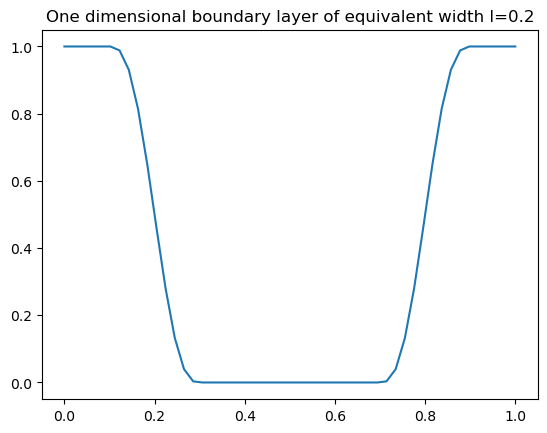

In [14]:
aX0 = xp.linspace(0,1)
X = xp.meshgrid(aX0,indexing='ij')
l = 0.2
plt.title(f"One dimensional boundary layer of equivalent width {l=}")
plt.plot(*X,layer(l,X));

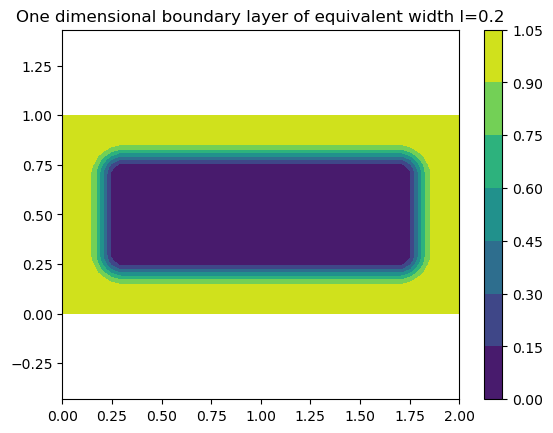

In [15]:
aX0 = xp.linspace(0,2)
aX1 = xp.linspace(0,1)
X = xp.meshgrid(aX0,aX1,indexing='ij')
l = 0.2
plt.title(f"One dimensional boundary layer of equivalent width {l=}")
plt.contourf(*X,layer(l,X))
plt.colorbar()
plt.axis('equal');

### 1.2 A complex synthetic medium

We construct some simple parametric models, with a fully anisotropic structure.
Our domain is $[-1,1]\times [0,1]$.

**Existing models.**
Classical models for wave propagation and seismologic reconstruction include the Marmousi model, and the BP 2007 TTI benchmark, as well as [a few others provided as open data by the SEG](https://wiki.seg.org/wiki/Open_data). However, these models are often incomplete in some regards w.r.t the physical properties description : the Marmousi model is isotropic, or at best VTI in some variants, and the BP2007 model lacks the model density and shear velocity. On the other hand, these models are also too big and complex for our illustration purposes.

**Layers of material.**
Let us define a VTI medium composed of a few layers of material, with varying thickness.

<!---

# Previous attempt with UniformGridInterpolation

layer_heights = xp.array([ 
    [0.8,0.7,0.7,0.75,0.8],  # Height of top layer
    [0.5,0.5,0.55,0.6,0.6],  # Height of middle layer
    [0.3,0.2,0.35,0.45,0.35] # Height of bottom layer
])
layer_heights_X = xp.linspace(-1,1,layer_heights.shape[1],endpoint=True)

height_fun = UniformGridInterpolation(layer_heights_X[None],layer_heights,order=2)
height_val = height_fun(aX[None]).T

In Layered Medium
#    height_fun = UniformGridInterpolation(heights_X[None],heights,order=2)
#    height_val = height_fun(X[0].reshape((-1,*shape))).reshape((len(heights),*shape))


# Previous attempt with extended data
# Thickness of the transition
layer_δ = 0.05

# Interpolation data
layer_heights = xp.array([ 
    [0.9,0.8,0.7,0.7,0.75,0.8],  # Height of top layer
    [0.55,0.5,0.5,0.55,0.6,0.6],  # Height of middle layer
    [0.6,0.3,0.2,0.35,0.45,0.35] # Height of bottom layer
])
layer_heights_X = xp.linspace(-1.2,1,layer_heights.shape[1],endpoint=True)

--->

In [16]:
nX = 100; dx = 1/nX
aX = xp.linspace(-1,1,2*nX+1,endpoint=True) # Horizontal axis
aZ = xp.linspace(0,1,nX+1,endpoint=True) # Vertical axis
X = xp.array(xp.meshgrid(aX,aZ,indexing='ij')) # Full coordinate system
shape = X.shape[1:] # Domain shape

In [17]:
layer_heights = xp.array([ 
    [0.8,0.7,0.7,0.75,0.8],  # Height of top layer
    [0.5,0.5,0.55,0.6,0.6],  # Height of middle layer
    [0.3,0.2,0.35,0.45,0.35] # Height of bottom layer
])
layer_heights_X = xp.linspace(-1,1,layer_heights.shape[1],endpoint=True)

# Thickness of the transition
layer_δ = 0.05

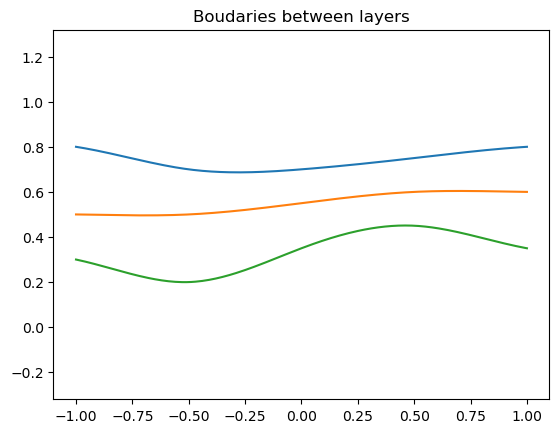

In [18]:
height_val = map_coordinates(layer_heights,aX[None],grid=layer_heights_X[None],order=3,mode='reflect').T
plt.title("Boudaries between layers")
plt.plot(aX, height_val);
plt.axis('equal');

Let us pick some arbitrary materials. 

In [19]:
# Materials for the acoustic wave
layer_ρ = xp.array((1.5,1,2,2.5))
layer_D = xp.array(([[1**2,0],[0,1**2]],[[2**2,0],[0,1**2]],[[3**2,0],[0,2**2]],[[2**2,0],[0,1.5**2]]))

# Materials for the elastic wave
materials = [Hooke.from_ThomsenElastic(Thomsen.ThomsenData[key]) for key in 
             ("Pierre shale - 1", "Mesaverde (4946) immature sandstone", 
              "Mesaverde (5501) clayshale", "Mesaverde sandstone (1958)") ]
layer_C = xp.array([hk.extract_xz().hooke for (hk,ρ) in materials])
layer_C = layer_C/np.max(layer_C) # normalization

The materials are placed in between the boundaries defined by the heights.

In [20]:
def LayeredMedium(X,heights,δ, ρs,Ds,caster=lambda x:x):
    shape = X.shape[1:]
    heights_X = caster(xp.linspace(-1,1,heights.shape[1],endpoint=True))
    height_val = map_coordinates(heights,X[0,None],grid=heights_X[None],
                                 order=3,mode='reflect').reshape((len(heights),*shape))
    heav = heaviside( (X[1,None]-height_val)/δ )
    partition = ad.array((heav[0],*[(1-heav[i])*heav[i+1] for i in range(len(heav)-1)],1-heav[-1]))
    partition /= partition.sum(axis=0) # Ensure partition of unity
    ρ_ = sum(ϕ * np.expand_dims(ρ,axis=(-2,-1)) for ϕ,ρ in zip(partition,ρs))
    D_ = sum(ϕ * np.expand_dims(D,axis=(-2,-1)) for ϕ,D in zip(partition,Ds))
    return ρ_,D_

In [21]:
ρ,D = LayeredMedium(X,layer_heights,layer_δ, layer_ρ,layer_D)

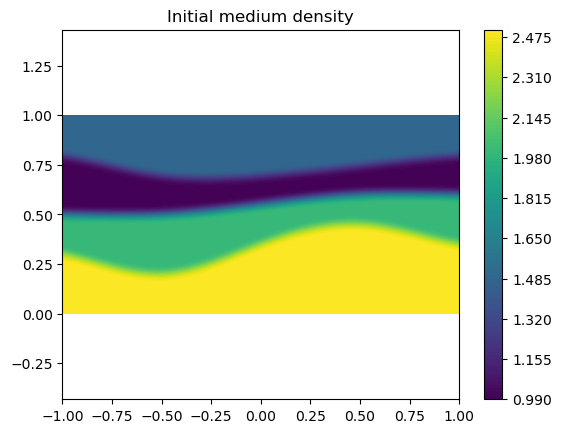

In [22]:
plt.title("Initial medium density")
plt.contourf(*X,ρ,100)
plt.axis('equal')
plt.colorbar(); 

**Diffeomorphic transformation**

We deform the layers, and rotate their elements. However, we do *not* apply the transformation in a way that leaves the wave PDE invariant. See the notebook on [high order waves](HighOrderWaves.ipynb) for that purpose.
<!---
    if grad_ad: # Use automatic differentiation to compute grad ϕ
        X_ad = ad.Dense.identity(constant=X,shape_free=(vdim,))
        ϕ_ad = ϕ(X_ad)
        ϕ_val = ϕ_ad.value
        ϕ_grad = ϕ_ad.gradient()
    else: # 
        ϕ_val = ϕ(X)
        ϕ_grad = grad(ϕ_val,X)

#    height_fun = UniformGridInterpolation(heights_X[None],heights,order=2)
#    def ϕ(X): X = ad.array(X); return ad.array((X[0],X[1]-height_fun(X[None,0],interior=True)))


There is one caveat though : we cannot use AD to differentiate the transformation $\phi$ if it takes arguments that also include AD. (This issue may be solved with proper typing, as in C++, but in Python it is hell.)
In that case, we approximate the gradient of $\phi$ using finite differences, with the option `grad_ad=False'.
--->

In [23]:
def decomp_OS(M,caster=lambda x:x):
    """
    Compute the orthogonal x symmetric decomposition 
    of a 2x2 matrix, in a way that is compatible with AD.
    """
    # Appears to be quite slow...
    S2 = lp.dot_AA(lp.transpose(M),M)
    a,b,c = S2[0,0],S2[0,1],S2[1,1]
    h,d = (a+c)/2, np.sqrt(((a-c)/2)**2+b**2)
    λ=h+d; μ = h-d # Eigenvalues of S^2 # Alternatively μ = det(S2)/λ is more accurate if μ << λ
    eye = caster(xp.eye(2)).reshape((2,2)+(1,)*a.ndim)
    S = (S2+np.sqrt(λ*μ)*eye)/(np.sqrt(λ)+np.sqrt(μ)) # Square root of matrix
    iS = lp.inverse(S,avoid_np_linalg_inv=True) # np.linalg.inv is incredibly slow
    return lp.dot_AA(M,iS),S

We use basic finite differences to compute $\nabla \phi$, since automatic differentation is not compatible with `map_coordinates` (as the position where to interpolate), and since anyway the differentiation w.r.t position and the differentiation w.r.t the arguments would be mixed up.

In [24]:
def grad(arr,X):
    """Numerical gradient. Assumes X is regularly spaced."""
    # There is a similar functionality in numpy, but it does not work with AD classes
    vdim = len(X)
    g = []
    for i in range(vdim):
        dx = X[(i,*(1,)*vdim)]-X[(i,*(0,)*vdim)]
        a = np.moveaxis(arr,i-vdim,0)
        da = np.concatenate(((a[1]-a[0])[None],(a[2:]-a[:-2])/2,(a[-1]-a[-2])[None]),axis=0)/dx
        g.append(np.moveaxis(da,0,i-vdim))
    return ad.array(g)                 

In [25]:
def DeformedLayeredMedium(ϕ,X,*args,caster=lambda x:x,**kwargs):
    """
    Transforms a layered medium according to provided diffeomorphism ϕ.
    (Material is rotated, but not stretched.)
    """
    vdim = len(X)
    ϕ_val = ϕ(X)
    ϕ_grad = grad(ϕ_val,X)
    O,_ = decomp_OS(lp.transpose(ϕ_grad),caster=caster)
    ρ,C = LayeredMedium(ϕ_val,*args,caster=caster,**kwargs)
    if len(C)==vdim: C = Riemann(C).inv_transform(O).m
    else: C = Hooke(C).inv_transform(O).hooke
    return ρ,C

In [26]:
def TopographicTransform(heights,caster=lambda x:x):
    """Vertical shift, interpolated according to data"""
    heights_X = caster(xp.linspace(-1,1,len(heights),endpoint=True))
    def ϕ(X):
        X = ad.array(X)
        height_val = map_coordinates(heights,X[0,None],grid=heights_X[None],
                                 order=3,mode='reflect')
        return ad.array((X[0],X[1]-height_val))
    return ϕ

In [27]:
topo_heights = 0.7*xp.array([0, 0.2, 0., 0., -0.3, 0.1]) # vertical shifts to interpolate

In [28]:
ϕ = TopographicTransform(topo_heights)

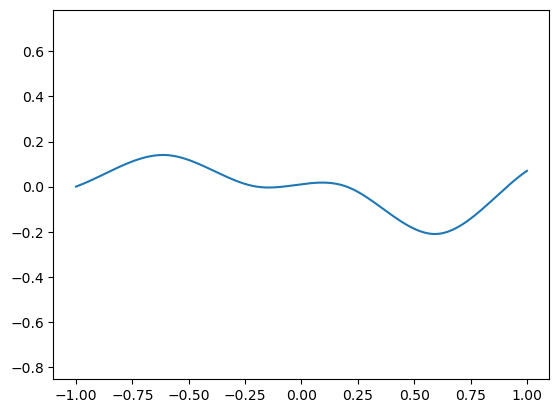

In [29]:
plt.plot(aX,-ϕ([aX,xp.zeros_like(aX)])[1])
plt.axis('equal');

In [30]:
layer_medium = DeformedLayeredMedium(ϕ,X,layer_heights,layer_δ, layer_ρ,layer_D)

In [31]:
ρ,D = layer_medium

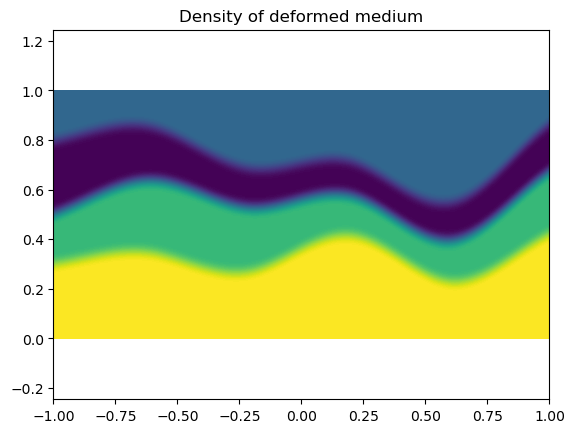

In [32]:
plt.title("Density of deformed medium")
plt.contourf(*X,ρ,100)
plt.axis('equal');

The (dual-)metric is now tilted and follows the oscillations of the topography.

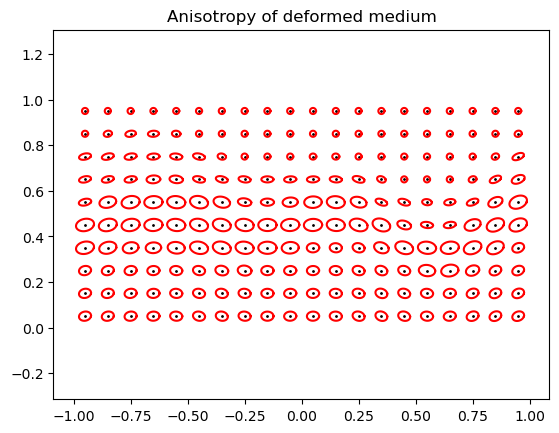

In [33]:
plt.title("Anisotropy of deformed medium")
Tissot(Riemann(D).dual(),X,subsampling=10)
plt.axis('equal');

**Inclusion.**
Inspired by e.g. salt domes in the BP 2007 benchmark, we add an inclusion of another material.

For that purpose, we average the two media, with a smooth but quickly varying weight. 

In [34]:
def inclusion(support0,medium0,medium1):
    """
    Weighted average of two media,
    using support0 as the weight function of medium0
    """
    ρ0,D0 = medium0
    ρ1,D1 = medium1
    support1 = 1-support0
    ρ0,D0,ρ1,D1 = [fd.as_field(e,support0.shape) for e in (ρ0,D0,ρ1,D1)]
    return ρ0*support0+ρ1*support1, D0*support0+D1*support1   

In [35]:
inc_ρ = 1.2
inc_D = xp.eye(2)
inc_radius = 0.25
inc_center = [-0.5,0.3]

In [36]:
inc_support = heaviside( (inc_radius - norm( X-fd.as_field(inc_center,shape),axis=0))/layer_δ)
inc_layer_medium = inclusion(inc_support,(inc_ρ,inc_D),layer_medium)

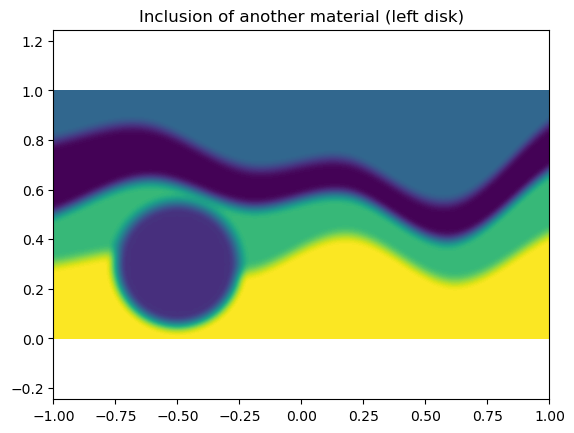

In [37]:
ρ,D = inc_layer_medium
plt.title("Inclusion of another material (left disk)")
plt.contourf(*X,ρ,100)
plt.axis('equal');

**Geological faults.**
Shifts happen. 

We average the medium with a shifted version of itself, using a support function which quickly varies accross a line.

In [38]:
shift_θ = π/3
shift_amplitude = 0.25
shift_origin    = xp.array([0.4,0.6])

In [39]:
s_o,s_d = [fd.as_field(e,X.shape[1:]) for e in (shift_origin,(np.cos(shift_θ),np.sin(shift_θ)))]
shift_medium = DeformedLayeredMedium(ϕ,X-s_d*shift_amplitude,layer_heights,layer_δ,layer_ρ,layer_D)
shift_support = heaviside(lp.det((X-s_o,s_d))/layer_δ)
final_medium = inclusion(shift_support,shift_medium,inc_layer_medium)

In [40]:
ρ,D = final_medium

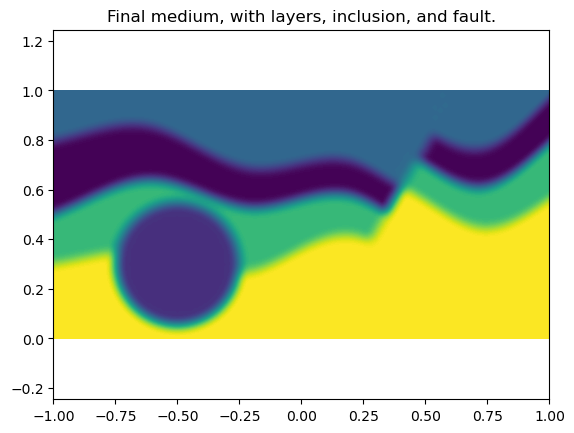

In [41]:
plt.title("Final medium, with layers, inclusion, and fault.") 
plt.contourf(*X,ρ,100)
plt.axis('equal');

### 1.3 Medium differentiation

We construct the above synthetic medium using simple and smooth (possibly on a short scale) primitives.
This makes them amenable to automatic differentiation, and we can thus differentiate the medium w.r.t the parameters. 

**Anisotropic tomography.**
Reconstructing a complete anisotropic medium from recordings on the boundary is likely impossible in general. 
Indeed, tomographic methods typically reconstruct an isotropic speed, or a density, but definitely not all 21 independent coefficients pointwise of a fully general Hooke tensor (21 in 3D, 6 in 2D).

However, if some prior knowledge is available, such as a parametrization of the model by a few parameters, then the identification of some anisotropy parameters may be feasible. Our objective is to find which (if any) of the parameters of the above parametrization can be reconstructed. For that purpose, a first step is to differentiate the model w.r.t the parameters.

**Performance of automatic differentiation.**
Unfortunately, the AD routines used in this subsection are not very computationally efficient, as they are implemented in pure Python (first-order forward AD). However, they should not be a critical part of the code. If needed, there is a lot of room for improvement, and some specialized software may also be leveraged.

In [42]:
def make_medium(X,
    # Layered medium
    layer_heights = layer_heights,
    layer_ρM = layer_ρ, # Acoustic : ρ. Elastic : M.
    layer_DC = layer_D, # Acoustic D. Elastic C. 
    layer_δ = layer_δ,

    # Deformation
    topo_heights = topo_heights,
    
    # Inclusion
    inc_ρM = inc_ρ,
    inc_DC = inc_D,
    inc_radius = inc_radius,
    inc_center = inc_center,
    
    # Shift
    shift_θ = shift_θ,
    shift_amplitude = shift_amplitude,
    shift_origin = shift_origin,
    caster=lambda x:x, # Optionally change array type 
):
    layer_heights,layer_ρM,layer_DC,topo_heights,inc_ρM,inc_DC,shift_origin = \
        map(caster,(layer_heights,layer_ρM,layer_DC,topo_heights,inc_ρM,inc_DC,shift_origin))
    shape = X.shape[1:]
    ϕ = TopographicTransform(topo_heights,caster=caster)
    layer_medium = DeformedLayeredMedium(ϕ,X,layer_heights,layer_δ,layer_ρM,layer_DC,caster=caster)
    
    inc_support = heaviside( (inc_radius - norm( X-fd.as_field(inc_center,shape),axis=0))/layer_δ)
    inc_layer_medium = inclusion(inc_support,(inc_ρM,inc_DC),layer_medium)

    s_o,s_d = [fd.as_field(e,shape) for e in (shift_origin,(np.cos(shift_θ),np.sin(shift_θ)))]
    shift_medium = DeformedLayeredMedium(ϕ,X-s_d*shift_amplitude,layer_heights,
                                         layer_δ,layer_ρM,layer_DC,caster=caster)
    shift_support = heaviside(lp.det((X-s_o,s_d))/layer_δ)
    
    final_medium = inclusion(shift_support,shift_medium,inc_layer_medium)
    return final_medium

Since the model is parametrized, we can easily generate variants, with e.g. blurrier transitions, a smaller inclusion, a fault with a different orientation. 

In [43]:
ρ,D = make_medium(X,layer_δ=0.1, inc_radius=0.15, shift_θ=2*π/3, shift_amplitude=-0.2 )

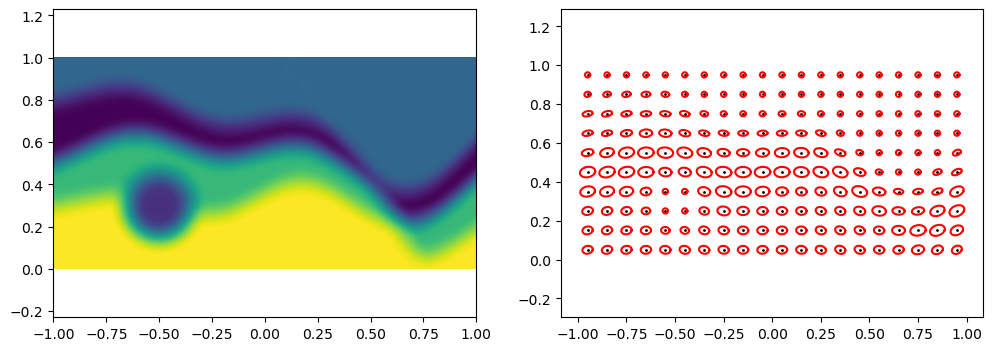

In [44]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1); plt.axis('equal')
plt.contourf(*X,ρ,100)
plt.subplot(1,2,2); plt.axis('equal')
Tissot(Riemann(D).dual(),X,subsampling=10);

We can also differentiate the model w.r.t any parameters.

In [45]:
layer_ρ_ad, inc_radius_ad = ad.Dense.register((layer_ρ, xp.array(inc_radius)))
ρ_ad,D_ad = make_medium(X,layer_ρM=layer_ρ_ad, inc_radius=inc_radius_ad)

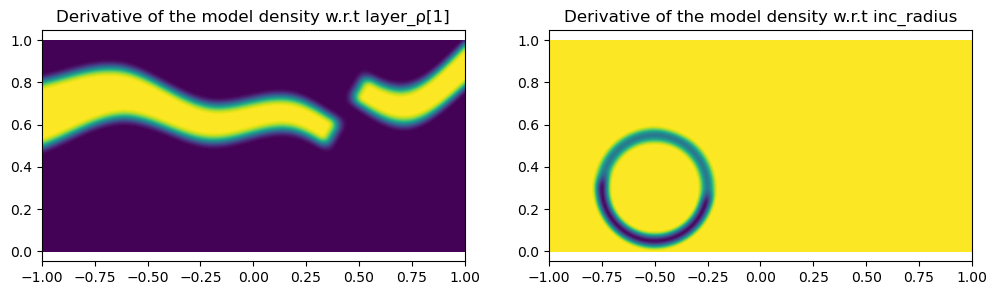

In [46]:
plt.figure(figsize=[12,3])
plt.subplot(1,2,1); plt.axis('equal')
plt.title("Derivative of the model density w.r.t layer_ρ[1]")
plt.contourf(*X,ρ_ad.gradient(1),100)
plt.subplot(1,2,2); plt.axis('equal')
plt.title("Derivative of the model density w.r.t inc_radius")
plt.contourf(*X,ρ_ad.gradient(4),100);

In [47]:
topo_heights_ad, shift_amplitude_ad = ad.Dense.register((topo_heights, xp.array(shift_amplitude)))
ρ_ad,D_ad = make_medium(X,topo_heights=topo_heights_ad, shift_amplitude=shift_amplitude_ad)

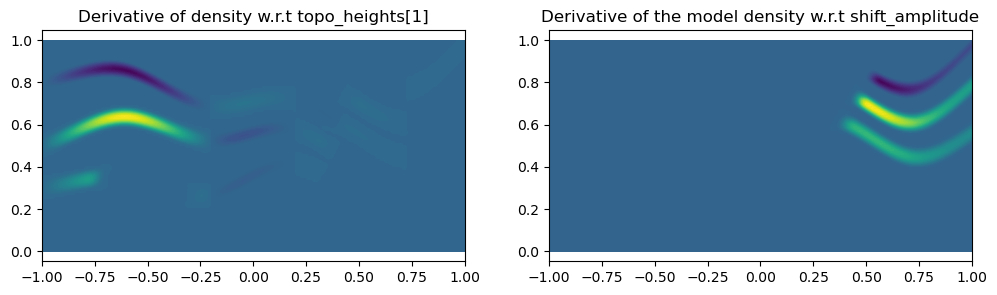

In [48]:
plt.figure(figsize=[12,3])
plt.subplot(1,2,1); plt.axis('equal')
plt.title("Derivative of density w.r.t topo_heights[1]")
plt.contourf(*X,ρ_ad.gradient(1),100)
plt.subplot(1,2,2); plt.axis('equal')
plt.title("Derivative of the model density w.r.t shift_amplitude")
plt.contourf(*X,ρ_ad.gradient(6),100);

## 2. Acoustic wave equation



### 2.1 Homogeneous example

We consider a homogeneous domain, i.e. the density $\rho$ and the metric $D$ are constant, and illustrate the effect of the damping layer.

In [49]:
dom,X,dx = make_domain(3,vdim=2)
ρ = 1.
#D = np.eye(2)
D = Riemann.from_diagonal((1,0.5)).rotate_by(π/6).m
q0 = churp(X)
p0 = np.zeros_like(q0)

dt_max = dx # Speed = 1
T = 1
niter = (int)(3*T/dt_max); dt = T/niter

**Propagation within the domain interior.**
Before considering boundary conditions, let us we have a look at the schemes of different accuracy orders in space and time, see the notebook on [high order schemes for wave equations](HighOrderWaves.ipynb).

Higher order schemes in space, `order_x=4`, lead to a more well rounded front but also to small spurious oscillations.

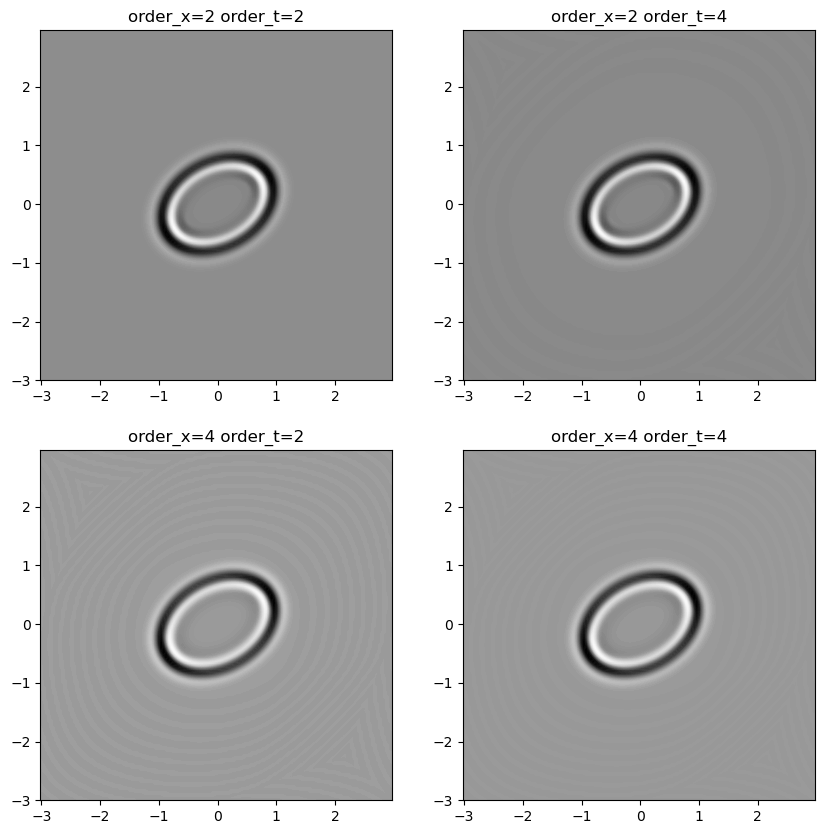

In [50]:
# The oscillations are small in amplitude, around the zero value, which is used in levelsets
nlevels = 100 # Using 100 or less contourf levels reveals the oscillations
# nlevels = 1000 # Using 1000 or more contourf levels hides the oscillations

plt.figure(figsize=[10,10]); iplot=1
for order_x in (2,4):
    H = AcousticHamiltonian(ρ,D,dx,shape_dom=dom.shape,order_x=order_x)
    for order_t in (2,4):
        q1,p1 = H.Sympl_p(q0,p0,dt,niter,order=order_t)
        plt.subplot(2,2,iplot); iplot+=1
        plt.title(f"{order_x=} {order_t=}")
        plt.contourf(*X,q1,nlevels,cmap='Greys')
        plt.axis('equal')

In this example, the wavelength is approximately $l=0.5$, and the speed is one.

<!---
l = 0.5 # As seen from above
α = 1.5 # Typical
r = 500 # Desired reduction
c = 1 # Wave speed

k = 2*π/l # Wave number
ω = c*k # Pulsation
l_damp = α*np.log(r)/k # Damping width
ω_damp = ω/α # Damping strength
damp_p = ω_damp * layer(l_damp,X)
--->

In [51]:
def damping_layer(X,k=None,ω=None,α=2,r=500,c=None,l=None):
    """
    Produce a damping (absorbing) layer on the boundary of X.
    - k : wave number. (Alternatively, provide the wavelength l.)
    - ω : pulsation of the signal (Alternatively, provide the speed c.)
    - α : relative thickness of the boundary layer transition, typical 1.5 <= α <= 3
    - r : desired amplitude reduction
    """
    if k is None: k=2*π/l # Wave number, inferred from wavelength
    if ω is None: ω = c*k # Pulsation, inferred from speed and wave number
    
    l_damp = α*np.log(r)/k # Damping width
    ω_damp = ω/α # Damping strength
    return ω_damp * layer(l_damp,X)

In [52]:
damp_p = damping_layer(X,l=0.5,c=1,α=1.5)

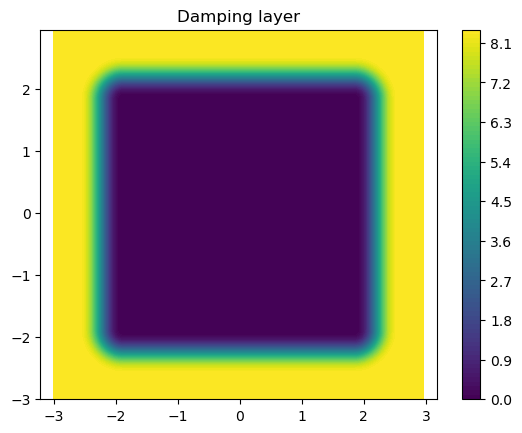

In [53]:
plt.title("Damping layer")
plt.contourf(*X,damp_p,100)
plt.axis('equal'); plt.colorbar();

The wave is attenuated as it goes through the damping layer. The choice of periodic or Neumann boundary condition has little incidence here.

*Warning :* current implementation of Neumann boundary conditions is only approximate, especially with anisotropic tensors.

In [54]:
# Codes for the different boundary conditions (implemented by padding values)
aw.bc_to_padding.keys()

dict_keys(['Periodic', 'Neumann', 'Dirichlet'])

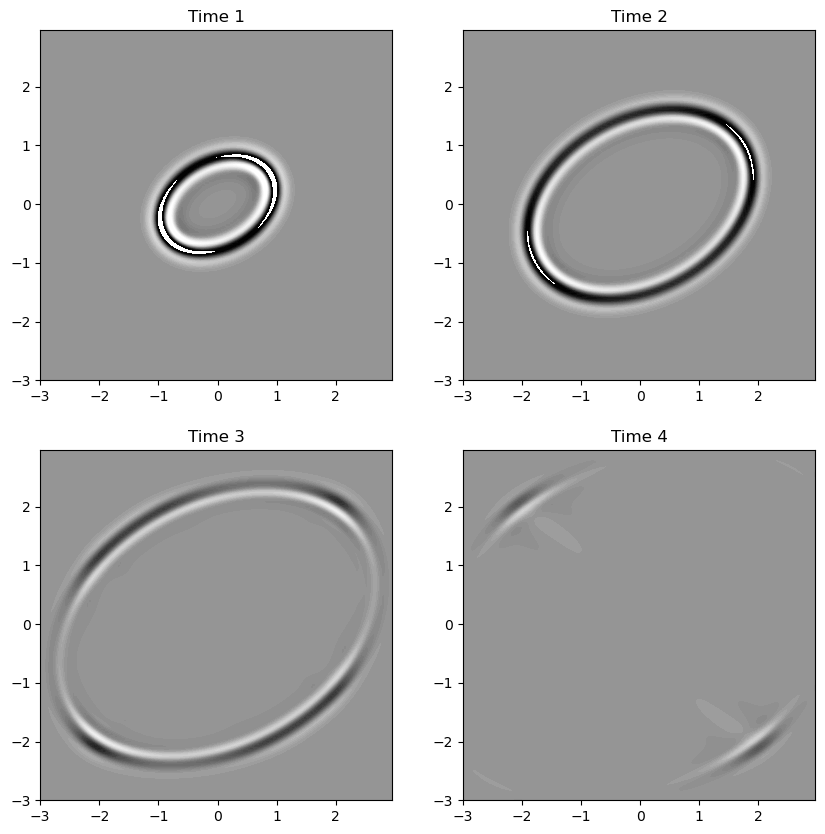

In [55]:
plt.figure(figsize=[10,10])
T=1
niter = (int)(3*T/dt_max); dt = T/niter
# Choose between 'Periodic', 'Neumann' (cpu only), and 'Dirichlet' 
bc = 'Neumann' if xp is np else 'Dirichlet' 

H = AcousticHamiltonian(ρ,D,dx,shape_dom=dom.shape,order_x=order_x,bc=bc) 
H.damp_p = damp_p # Try to remove it !

q1,p1 = q0,p0
levels = np.linspace(-15,15)
for i in range(4):
    q1,p1 = H.Sympl_p(q1,p1,dt,niter,order=2) 
    q1,p1 = H.Damp_qp(q1,p1,dt) # Damping steps are interleaved, adding a final one for consistency
    plt.subplot(2,2,1+i)
    plt.title(f"Time {(i+1)*T:.2g}")
    plt.contourf(*X,q1,levels,cmap='Greys')

### 2.2 Complex medium

We use the medium constructed in the first part of the notebook, and show how to extract seismograms.

<!---
We use the classical BP 2007 TTI test case, but replace the TTI norm with an elliptic approximation. 
--->

In [56]:
nX = 150; dx = 1/nX
aX = xp.linspace(-1,1,2*nX+1,endpoint=True) # Horizontal axis
aZ = xp.linspace(0,1,nX+1,endpoint=True) # Vertical axis
X = xp.array(np.meshgrid(aX,aZ,indexing='ij')) # Full coordinate system
order_x=2; order_t=2;
bc='Neumann' if xp is np else 'Dirichlet'

σ = 2.5*dx # Approximate radius of initial impulsion
x0 = (0.,0.7)
q0 = churp(X,σ,x0)
p0 = np.zeros_like(q0)
rec_height = 0.75 # We'll record the signal at this depth

In [57]:
ρ,D = make_medium(X)

In [58]:
H = AcousticHamiltonian(ρ,D,dx,order_x=order_x,bc=bc)
dt_max = H.dt_max()

We use a damping layer all around. Physically relevant boundary conditions, such as Neumann boundary conditions on part of the domain in the case of free surface, are not implemented presently. 
Note that the damping layer construction assumed constant coefficients. For best efficiency, it should be adapted in the case of complex media as here.

In [59]:
H.damp_p = damping_layer(X,c=2*dx/dt_max,l=5*σ)

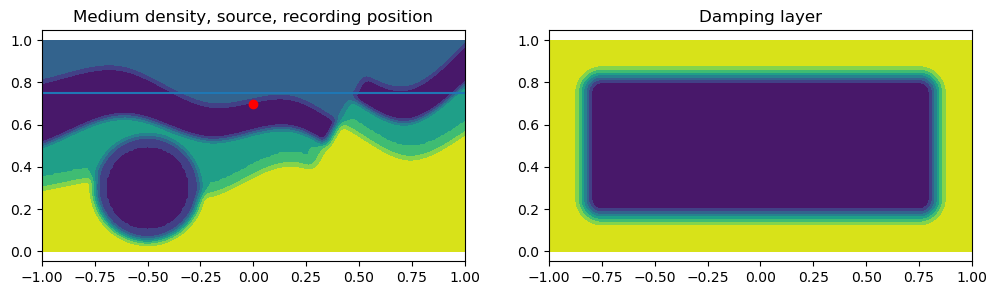

In [60]:
plt.figure(figsize=[12,3])
plt.subplot(1,2,1); plt.title("Medium density, source, recording position")
plt.contourf(*X,ρ)
plt.scatter(*x0,color='red')
plt.axhline(rec_height)
plt.axis('equal');
plt.subplot(1,2,2); plt.title("Damping layer")
plt.contourf(*X,H.damp_p);
plt.axis('equal');

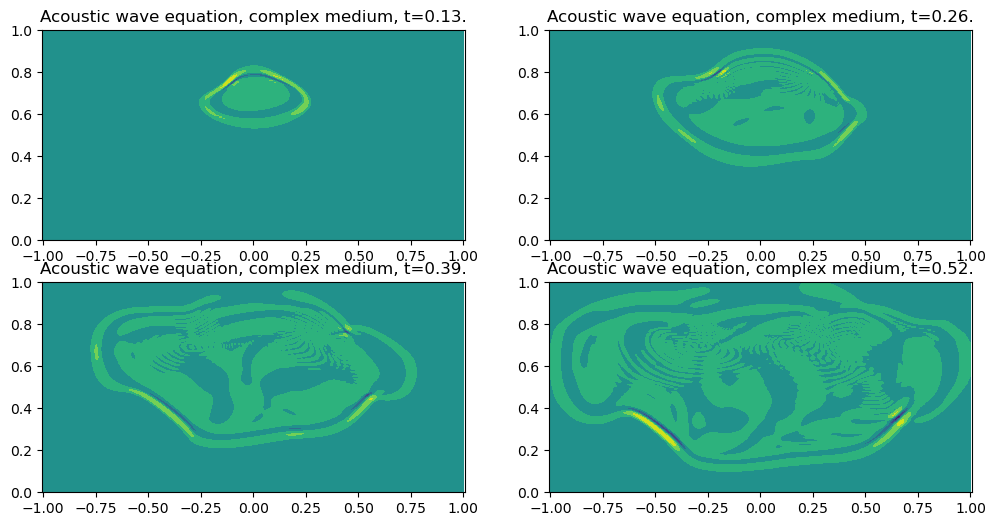

In [61]:
plt.figure(figsize=[12,6])
dt = H.dt_max(order_t)
niter=50
q1,p1 = q0,p0

for i in range(4):
    q1,p1 = H.Sympl_p(q1,p1,dt,niter,order_t)
    q1,p1 = H.Damp_qp(q1,p1,dt) # Additional damping step for consistency
    plt.subplot(2,2,i+1)
    plt.title(f"Acoustic wave equation, complex medium, t={(i+1)*niter*dt:.2g}.")
    plt.contourf(*X,q1)
    plt.axis('equal');

Let us extract some seismogram data, at a given depth.

In [62]:
rec_spacing = 0.02 # Horizontal spacing between two successive recordings
rec_q = []
q1,p1 = q0,p0
niter=400
for i in range(niter):
    q1,p1 = H.Sympl_p(q1,p1,dt,order=order_t)
    rec_q.append(q1[::int(rec_spacing/dx),int(rec_height/dx)])    
    q1,p1 = H.Damp_qp(q1,p1,dt)
rec_q = ad.array(rec_q)

We display the seismogram using the `Asinh` scale, which is linear near the zero, and logarithmic for large values.

Note that we clearly see the effect of the reflection on the right, left and top boundaries. There is clearly some room for improvement in the tuning of the absorbing boundary conditions.

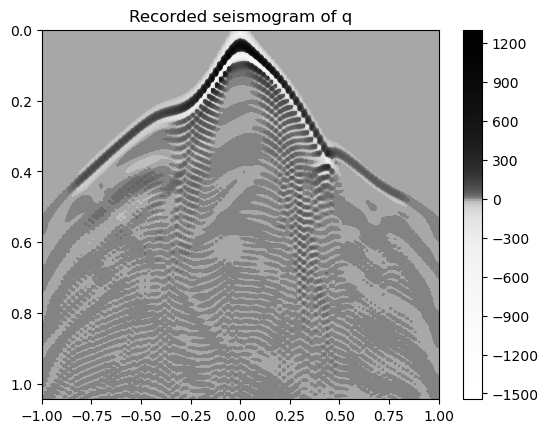

In [63]:
plt.title("Recorded seismogram of q")
rec_T = xp.arange(niter)*dt
rec_X = xp.linspace(-1,1,len(rec_q[0]))
plt.contourf(rec_X,rec_T,rec_q,levels=200,cmap='Greys',norm=AsinhNorm(linear_width = 10))
plt.gca().invert_yaxis()
plt.colorbar();

## 3 Automatic differentiation of seismograms

### 3.1 Forward differentiation

The final objective of seismograhy is usually to invert the seismogram signal, i.e. to recover the underground composition from the recordings. For that purpose, optimization methods are used, typically relying on gradient information, such as L-BFGS.

As a first step, we differentiate the final value and the seismogram obtained in [2.2 Complex medium](#2.2-Complex-medium) w.r.t. the medium properties.

In [64]:
# Four independent symbolic perturbations
δ_ad = ad.Dense.identity(constant=xp.zeros(4))

# Symbolic perturbation of the topographic change of variables
topo_heights_ad = ad.Dense.denseAD(topo_heights)
topo_heights_ad[3] += δ_ad[0]

# Symbolic perturbation of the vertical position of the inclusion
inc_center_ad = ad.Dense.denseAD(inc_center)
inc_center_ad[1] += δ_ad[1]

# Symbolic perturbation of the fault position
shift_origin_ad = ad.Dense.denseAD(shift_origin)
shift_origin_ad[0] += δ_ad[2]

# Symbolic perturbation of the orientation of the anisotropy
layer_D_ad = ad.Dense.denseAD(layer_D)
layer_D_ad[2] = Riemann(layer_D_ad[2]).rotate_by(-δ_ad[3]).m

In [65]:
ρ_ad,D_ad = make_medium(X,topo_heights=topo_heights_ad,inc_center=inc_center_ad,
                        shift_origin=shift_origin_ad,layer_DC=layer_D_ad)

Note that the latest symbolic perturbation mainly affects the off-diagonal coefficients of the dual-metric $D$. 
This is really a non-isotropic and non-vti effect.

<!---
test = ad.Dense.denseAD(np.array([1.,2.]))
test.reshape(-1)
test = ad.Sparse.spAD(np.array([1.,2.]))
test.reshape(-1)
test = ad.Dense2.denseAD2(np.array([1.,2.]))
test.reshape(-1)
test = ad.Sparse2.spAD2(np.array([1.,2.]))
test.reshape(-1)
--->

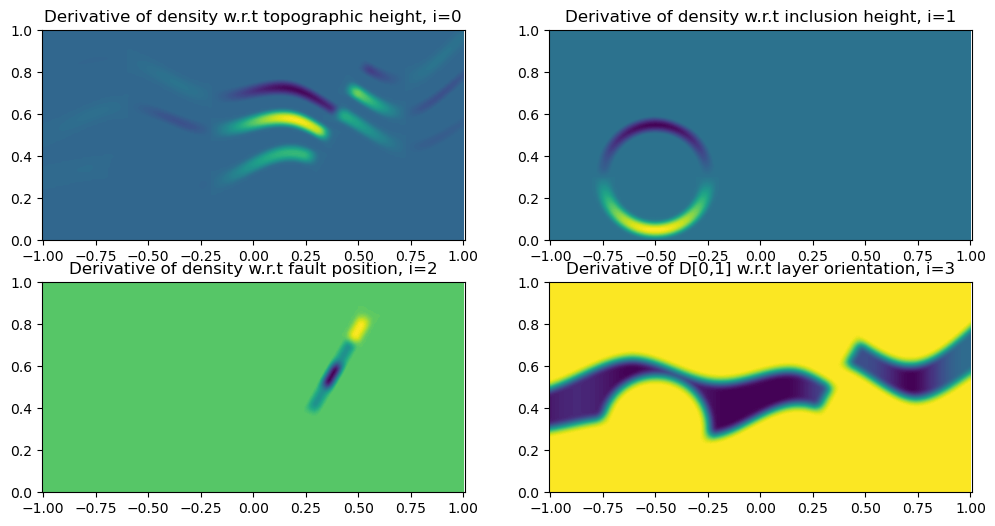

In [66]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1); plt.title("Derivative of density w.r.t topographic height, i=0")
plt.contourf(*X,ρ_ad.gradient(0),100); plt.axis('equal')
plt.subplot(2,2,2); plt.title("Derivative of density w.r.t inclusion height, i=1")
plt.contourf(*X,ρ_ad.gradient(1),100); plt.axis('equal')
plt.subplot(2,2,3); plt.title("Derivative of density w.r.t fault position, i=2")
plt.contourf(*X,ρ_ad.gradient(2),100); plt.axis('equal')
plt.subplot(2,2,4); plt.title("Derivative of D[0,1] w.r.t layer orientation, i=3")
plt.contourf(*X,D_ad[0,1].gradient(3),100); plt.axis('equal');

In [67]:
H_ad = AcousticHamiltonian(ρ_ad,D_ad,dx,order_x=order_x,bc=bc)

In [68]:
H_ad.damp_p = H.damp_p

In [69]:
q0_ad,p0_ad = ad.Dense.denseAD(q0),ad.Dense.denseAD(p0)
niter = 150
q1,p1 = H_ad.Sympl_p(q0_ad,p0_ad,dt,niter,order_t)

We differentiate the solution w.r.t each of the four considered symbolic perturbations of the medium. 
Note that the obtained symbolic perturbation of the solution has a wide support, because these perturbations propagate, are reflected, etc.

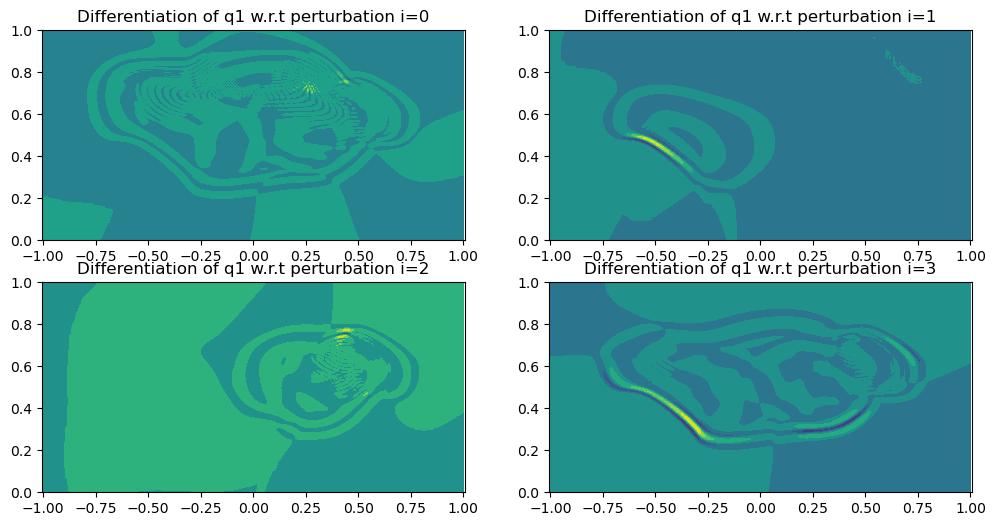

In [70]:
plt.figure(figsize=[12,6])
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(f"Differentiation of q1 w.r.t perturbation {i=}")
    plt.contourf(*X,q1.gradient(i))
    plt.axis('equal')

In [71]:
rec_q_ad = []
q1,p1 = q0_ad,p0_ad
niter=400
for i in range(niter):
    q1,p1 = H_ad.Sympl_p(q1,p1,dt,order=order_t)
    rec_q_ad.append(q1[::int(rec_spacing/dx),int(rec_height/dx)])    
    q1,p1 = H_ad.Damp_qp(q1,p1,dt)
rec_q_ad = ad.asarray(rec_q_ad)

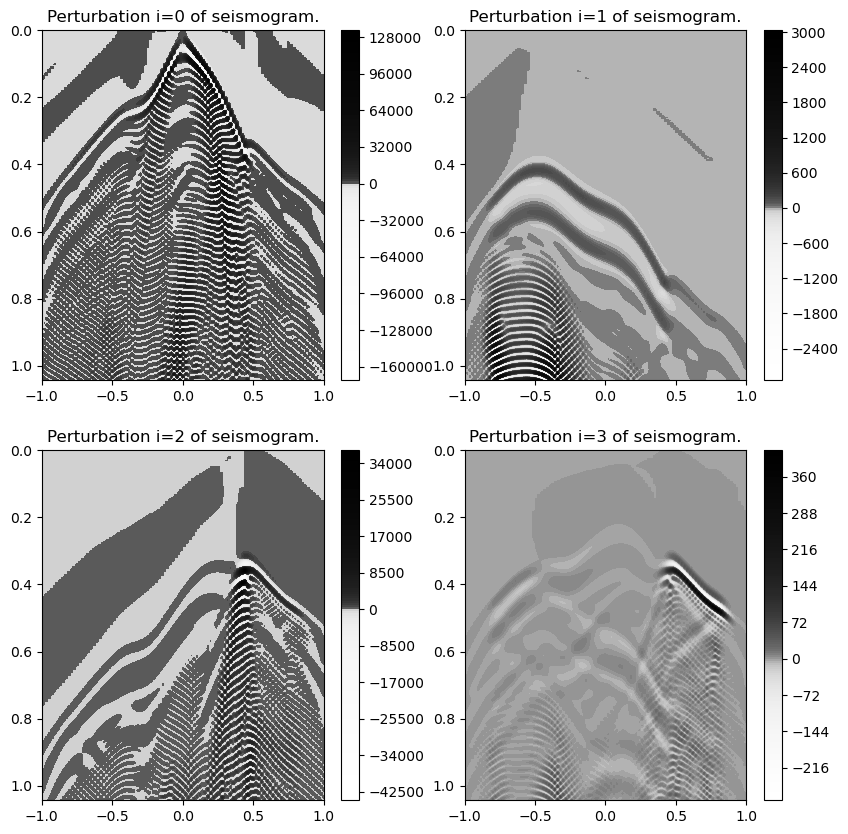

In [72]:
plt.figure(figsize=[10,10])
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(f"Perturbation {i=} of seismogram.")
    plt.contourf(rec_X,rec_T,rec_q_ad.gradient(i),levels=200,cmap='Greys',norm=AsinhNorm(linear_width = 10))
    plt.gca().invert_yaxis()
    plt.colorbar();

**Errors introduced by the finite differences computation of the gradient of the change of variables.**

In [73]:
assert norm(D-D_ad.value) / norm(D) < 1e-3 # Relative error on the anisotropy coefficients
assert norm(ρ-ρ_ad.value) / norm(ρ) < 1e-8 # With this choice of topography, ρ is preserved exactly
assert norm(rec_q - rec_q_ad.value) / norm(rec_q) < 5e-4 # Relative error on the seismograms

**AGD library function.**
The AGD library does provide a function for extracting seismograms. 
Its main interest lies in the backpropagation facilities, discussed in the next subsection, but let us nevertheless illustrate it here.

First we need to find which indices are used in building the seismograms.

In [74]:
q_range = xp.arange(q0.size).reshape(q0.shape)
qh_ind = np.unravel_index(q_range[::int(rec_spacing/dx),int(rec_height/dx)],q_range.shape)
print("Elements of q extracted at each iteration for the seismogram : \n",qh_ind)

Elements of q extracted at each iteration for the seismogram : 
 (array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
        39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
        78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
       117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153,
       156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192,
       195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231,
       234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270,
       273, 276, 279, 282, 285, 288, 291, 294, 297, 300]), array([112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112,

In [75]:
qf,pf,qh,ph = H.seismogram(q0,p0,dt,niter,order=order_t,qh_ind=qh_ind)

- `qf` and `pf` are the *final* values of the waves
- `qh` and `ph` are the recorded *history* of the waves, i.e. the seismograms. The last iteration is not included, access it via qf,pf.

In [76]:
print(f"Without ph_ind, the impulsion seismogram is not recorded : {ph=}")
atol=1e-3 if xp is not np else 1e-8
assert np.allclose(qh,rec_q[:-1],atol=atol) 
assert np.allclose(qf[*qh_ind],rec_q[-1],atol=atol)

Without ph_ind, the impulsion seismogram is not recorded : ph=array([], dtype=float64)


In [77]:
qf_ad,_,qh_ad,_ = H_ad.seismogram(q0_ad,p0_ad,dt,niter,order=order_t,qh_ind=qh_ind)

In [78]:
if xp is np:
    assert np.allclose(qh_ad,rec_q_ad[:-1],atol=1)
    assert np.allclose(qf_ad[*qh_ind],rec_q_ad[-1],atol=1)
else: # More substantial roundoff error using 32 bit floats on GPU
    assert np.allclose(qh_ad.value,rec_q_ad[:-1].value,atol=atol)
    assert np.allclose(qf_ad[*qh_ind].value,rec_q_ad[-1].value,atol=atol)
    # atol=1 seems large, but the values are large, and time evolution is long
    assert np.allclose(qh_ad.coef,rec_q_ad[:-1].coef,atol=1)
    assert np.allclose(qf_ad[*qh_ind].coef,rec_q_ad[-1].coef,atol=1)

### 3.2 Reverse differentiation

Consider a numerical function $f : R^m \to R^n$, expressed as a composition of elementary steps $f = f_1 \circ \cdots \circ f_k$, to which one wishes to apply automatic differentiation. We recall that :
- forward AD is recommended if $m=\cO(1)$, i.e. the source space is simple.
- reverse AD is recommended if $n=\cO(1)$, i.e. the target space is simple.
- sparse AD is recommended if $k = \cO(1)$, i.e. $f$ has a simple structure.

We already used forward AD to compute the dependence of the sismogram (a large target), w.r.t a few medium parameters (a small source).
We also used sparse AD under the hood construct the finite differences scheme (a simple function, from a large source to a large target) from the Hamiltonian energy.

However reverse AD is the best fit in tomographic inversion, where one usually wants the seismogram to minimize some energy functional (the target is a single scalar), when the medium varies (the source is defined by many parameters), using gradient descent, or possibly more complex optimization routines such as L-BFGS. 

**Objective functionals.**
$\newcommand\gS{\mathfrak{S}}$
In tomographic inversion, one attempts to fit a computed seismogram $\gS(m)$ depending on the medium parameters $m$, to a recorded seismogram $\gS_*$. This is typically achieved by minimizing locally via gradient descent a mapping of the form
$$
    m \mapsto \cD(\gS(m)||\gS_*) + \cE(m).
$$
- The *divergence function* $\cD$ penalizes the differences between $\gS(m)$ and $\gS_*$. There are many possibilities, but the simplest one is simply the $L^2$ distance, possibly with some lowpass filtering, e.g :
\begin{align*}
    \cD(\gS||\gS_*) &= \frac 1 2 \|\gS-\gS_*\|^2_\sigma, &
    \text{with } \|\gS-\gS_*\|_\sigma^2 &:= \int_{X \times X} u(x) G_\sigma(x-y) u(y)\, \diff x \diff y = \<u,G_\sigma \star u\>,
\end{align*}
where $G_\sigma$ is a Gaussian kernel of width $\sigma\geq 0$, and convolution is denoted by $\star$.
- The *regularization function* $\cE$ penalizes excessively unlikely medium, such as one featuring quick oscillations.
Again, there are many possibilities, especially since the structure of underground media is rather unstructured and complex, with layers, inclusions, faults, etc as illustrated above.
For simplicity, we may assume a quadratic functional, e.g.
$$
    \cE(m) = \frac 1 2 \int_X |m(x)|^2 + \tilde \sigma^2|\nabla m(x)|^2 \diff x = \frac 1 2 \<m,Lm\>,
$$
where $\tilde \sigma\geq 0$ is a smoothing parameter.

Alternatively, we can use a parametrized model, in which $m$ is not a field defined over the PDE domain, but a collection of parameters to be reconstructed, see [1. Models construction](#1.-Models-construction). 

**Gradient descent.**
A semi-implicit gradient descent for the above energy reads
\begin{equation*}
    \frac{m'-m} \tau = [\Diff \gS(m)]^\top \nabla_1 \cD(\gS(m),\gS_*)  + \nabla \cE(m').
\end{equation*}
With the choices discussed above, one has $\nabla_1 \cD(\gS(m),\gS_*) = G_\sigma \star (\gS(m)-\gS_*)$, and $\nabla \cE(m')$, which amounts to 
\begin{equation*}
     m' = (1+\tau L)^{-1} \Big(m - \tau [\Diff \gS(m)]^\top G_\sigma \star (\gS(m)-\gS_*) \Big).
\end{equation*}
The objective of reverse AD is to efficiently compute $[\Diff \gS(m)]^\top \xi$, for any given $\xi$. Note that the inversion $(1+\tau L)^{-1}$ amounts to a smoothing effect. 

In [79]:
niter=400

**Construction of the reference data.**
We have no physically recorded data, so we generate a reference by propagating within a different medium.

In [80]:
 # Four medium perturbations
δ_ref = np.array([0.1,-0.6,0.2,0.7])*0.1

# Perturbation of the topographic change of variables
topo_heights_ref = topo_heights.copy()
topo_heights_ref[3] += δ_ref[0]

# Perturbation of the vertical position of the inclusion
inc_center_ref = inc_center.copy()
inc_center_ref[1] += δ_ref[1]

# Perturbation of the fault position
shift_origin_ref = shift_origin.copy()
shift_origin_ref[0] += δ_ref[2]

# Perturbation of the orientation of the anisotropy
layer_D_ref = layer_D.copy()
layer_D_ref[2] = Riemann(layer_D_ref[2]).rotate_by(-δ_ref[3]).m

Generate the reference medium, Hamiltonian, and reference solution and seismogram.

<!---
assert np.allclose(q0_ad.value,q0)
assert np.allclose(p0_ad.value,p0)
assert np.allclose(ρ_ad.value,ρ_ref)
assert np.allclose(D_ad.value,D_ref)
--->

In [81]:
ρ_ref,D_ref = make_medium(X,topo_heights=topo_heights_ref,inc_center=inc_center_ref,
                        shift_origin=shift_origin_ref,layer_DC=layer_D_ref)
H_ref = AcousticHamiltonian(ρ_ref,D_ref,dx,bc=bc)
H_ref.damp_p = H.damp_p # Use the same damping layers
ph_ind = qh_ind # Also record impulsion.
qf_ref,pf_ref,qh_ref,ph_ref = H_ref.seismogram(q0,p0,dt,niter,qh_ind=qh_ind,ph_ind=ph_ind)

**Construction of the divergence function.**

<!---
def mk_discr_gradient(qf_ref,pf_ref,qh_ref,ph_ref,
                      qf_w,pf_w,qh_w,ph_w):
    def dicr
    return 
--->

In [82]:
def gf(x,σ,filter=ndimage.gaussian_filter):
    """Gaussian filter, also applying to denseAD variables."""
    if np.isscalar(σ): σ = (σ,)*x.ndim
    if isinstance(x,ad.Dense.denseAD): return ad.Dense.denseAD(gf(x.value,σ,filter),gf(x.coef,(*σ,0),filter))
    else: return filter(x,σ)

def gf2(x,*args,**kwargs): 
    """Half squared norm of a lowpass filtering of x. Gradient is gf."""
    return 0.5*np.sum(x*gf(x,*args,**kwargs))

The objective functional is defined here as an arbitrary weighted sum of the errors on the sismogram and final state of position and momentum. In tomography, one expects to have `qf_w = pf_w = 0`, since the final state (qf_ref, pf_ref) in the whole domain cannot be measured.

<!---
    return sum([w* gf2(x-x_ref,*args,**kwargs) for w,x,x_ref in 
                ((qf_w,qf,qf_ref), (pf_w,pf,pf_ref), (qh_w,qh,qh_ref), (ph_w,ph,ph_ref))])

def obj_grad(qf,pf,qh,ph,
             qf_w,pf_w,qh_w,ph_w,σ): 
    """Gradient of the objective functional."""
    # We add one final singleton dimension. Several gradients may be concatenated along the last axis for backprop.
    return [w* gf(x-x_ref,σ)[...,None] for w,x,x_ref in 
            ((qf_w,qf,qf_ref), (pf_w,pf,pf_ref), (qh_w,qh,qh_ref), (ph_w,ph,ph_ref))]

def obj(qf,pf,qh,ph,
        qf_w,pf_w,qh_w,ph_w,σ):
    """The objective functional, measuring the discrepancy between calculated and reference seismograms."""
    return sum([w* gf2(x-x_ref,σ) for w,x,x_ref in 
              ((qf_w,qf,qf_ref), (pf_w,pf,pf_ref), (qh_w,qh,qh_ref), (ph_w,ph,ph_ref))])

    qf_grad,pf_grad,qh_grad,ph_grad = obj_grad(qf,pf,qh,ph,*args,**kwargs)
    return 0.5*sum( np.sum(x*x_grad[...,0]) for x,x_grad in ((qf,qf_grad),(pf,pf_grad),(qh,qh_grad),(ph,ph_grad))) 
--->

In [83]:
def mk_obj(qf_ref,pf_ref,qh_ref,ph_ref,  qf_w,pf_w,qh_w,ph_w,  σ):
    """Construct a basic objective functional and its gradient"""
    def obj(qf,pf,qh,ph): 
        return sum([w* gf2(x-x_ref,σ) for w,x,x_ref in 
              ((qf_w,qf,qf_ref), (pf_w,pf,pf_ref), (qh_w,qh,qh_ref), (ph_w,ph,ph_ref))])
        
    def grad(qf,pf,qh,ph):
        # We add one final singleton dimension. Backprop allows several gradients to be concatenated along the last axis.
        return [w* gf(x-x_ref,σ)[...,None] for w,x,x_ref in 
            ((qf_w,qf,qf_ref), (pf_w,pf,pf_ref), (qh_w,qh,qh_ref), (ph_w,ph,ph_ref))]
    return obj,grad

In [84]:
# Arbitrary weights given to the different data, for the objective functional
obj,obj_grad = mk_obj(qf_ref,pf_ref,qh_ref,ph_ref,  
                      qf_w=1.5,pf_w=0.5,qh_w=2,ph_w=1,  σ=2)

Let us check that the `gaussian_filter` implementation is self-adjoint, as required.

In [85]:
np.random.seed(42)
shape = (10,10); x = xp.asarray(rand(*shape)); y = xp.asarray(rand(*shape))
assert np.allclose(np.sum(gf(x,π)*y), np.sum(x*gf(y,π)))

**Forward AD.**
We obtain the gradient of the objective functional w.r.t the considered perturbations of the medium.

In [86]:
ρ = ρ_ad.value; D = D_ad.value; 
H_fwd = AcousticHamiltonian(ρ_ad,D_ad,dx,bc=bc,save_weights=True); H_fwd.damp_p = H.damp_p

In [87]:
qf_fwd,pf_fwd,qh_fwd,ph_fwd = H_fwd.seismogram(q0_ad,p0_ad,dt,niter,qh_ind=qh_ind,ph_ind=ph_ind)

In [88]:
obj_fwd = obj(qf_fwd,pf_fwd,qh_fwd,ph_fwd)

In [89]:
obj_fwd = obj(qf_fwd,pf_fwd,qh_fwd,ph_fwd)
grad_fwd = obj_fwd.gradient()
with np.printoptions(suppress=True,precision=5): print(f"Normalized gradient {grad_fwd/norm(grad_fwd)}")

Normalized gradient [-0.799    0.00126 -0.60132 -0.00423]


In [90]:
obj_fwd.gradient()

array([-3.02848152e+12,  4.77218741e+09, -2.27921817e+12, -1.60226825e+10])

Observations : 
- The first component of the gradient, related to the topographic change of variables, is much larger than the others. The large difference in sensibility depending on the parameters can be annoying in the context of gradient descent, and it is one of the reasons why e.g. L-BFGS methods provide substantial improvement.
- The signs of the gradient are opposite to the signs of the perturbations, which is good : it means gradient descent goes in the right direction, towards finding the reference parameters.

In [91]:
print(δ_ref)

[ 0.01 -0.06  0.02  0.07]


**Reverse AD.**
We perform the same computation using reverse AD. Note that this does not have much interest here since we vary only four parameters, but in general one has many more (possibly several for reach grid point).

In [92]:
H_rev = AcousticHamiltonian(ρ,D,dx,bc=bc,rev_ad=1,save_weights=True); H_rev.damp_p = H.damp_p
#H_rev.Impl2_p_merged = False

In [93]:
qf_rev,pf_rev,qh_rev,ph_rev,backprop = H_rev.seismogram_with_backprop(q0,p0,dt,niter,qh_ind=qh_ind,ph_ind=ph_ind)
#qf_rev,pf_rev,qh_rev,ph_rev = H_rev.seismogram(q0,p0,dt,niter,qh_ind=qh_ind,ph_ind=ph_ind)

Forward propagation does not compute any AD information. 

In [94]:
norm(pf_rev-pf_fwd.value,np.inf)

2.632987161632627e-10

In [95]:
if xp is np:
    assert np.allclose(qf_rev,qf_fwd.value)
    assert np.allclose(pf_rev,pf_fwd.value)
    assert np.allclose(qh_rev,qh_fwd.value)
    assert np.allclose(ph_rev,ph_fwd.value)
else: # More substantial roundoff errors on the GPU
    assert np.allclose(qf_rev,qf_fwd.value,atol=norm(qf_rev,np.inf)*1e-4)
    assert np.allclose(pf_rev,pf_fwd.value,atol=norm(pf_rev,np.inf)*1e-4)
    assert np.allclose(qh_rev,qh_fwd.value,atol=norm(qh_rev,np.inf)*1e-5)
    assert np.allclose(ph_rev,ph_fwd.value,atol=norm(ph_rev,np.inf)*1e-5)

Now let us backpropagate the gradient of the objective functional through the symplectic scheme.
(We choose here to avoid as much as possible the symplectic formalism, which is taken care of within the backprop.)

In [96]:
H_rev.rev_reset()
q0_grad,p0_grad = backprop(*obj_grad(qf_rev,pf_rev,qh_rev,ph_rev))

Now we have two ways of evaluating the gradient of the energy functional w.r.t the medium parameters : 
- either propagate forward through the symplectic scheme, and express it in terms of final state and seismograms
- or propagate backward through the symplectic scheme, and express it in terms of initial state and parameters.

<!---
def _fwd_grad(qf_fwd, pf_fwd, qh_fwd, ph_fwd,
             qf_grad,pf_grad,qh_grad,ph_grad):
    """Gradient of the objective functional obtained via forward AD"""
    return (np.sum(qf_grad*qf_fwd[...,None] + pf_grad*pf_fwd[...,None])
          + np.sum(qh_grad*qh_fwd[...,None]) + np.sum(ph_grad*ph_fwd[...,None])).coef

def _rev_grad(q0_fwd, p0_fwd, H_fwd,
             q0_grad,p0_grad,H_rev):
    """Gradient of the objective functional obtained via reversed AD"""
    return (np.sum(q0_grad*q0_fwd[...,None] + p0_grad*p0_fwd[...,None]) \
          + np.sum(H_rev.iρ.coef*H_fwd.iρ[...,None]) - np.sum(H_rev.weights.coef*H_fwd.weights[...,None])).coef
--->

In [97]:
if q0_ad.size_ad==0: q0_ad.coef = np.zeros_like(qf_fwd.coef)
if p0_ad.size_ad==0: p0_ad.coef = np.zeros_like(pf_fwd.coef)

In [98]:
# Gradient of objective functional w.r.t sismogram and final state
qf_grad,pf_grad,qh_grad,ph_grad = obj_grad(qf_rev,pf_rev,qh_rev,ph_rev)

# Gradient of objective functional w.r.t medium parameters, via forward AD
grad1 = fwd_grad(qf_fwd, pf_fwd, qh_fwd, ph_fwd, qf_grad,pf_grad,qh_grad,ph_grad) 

# Gradient of objective functional w.r.t medium parameters, via reverse AD
grad2 = rev_grad(q0_ad, p0_ad, H_fwd, q0_grad,p0_grad,H_rev)

In [99]:
rtol=rtol=1e-8 if xp is np else 3e-4
assert np.allclose(grad1,grad2,rtol=rtol) # Different computation
assert np.allclose(grad1,grad_fwd[:,None],rtol=rtol) # Essentially the same computation, just checking

### 3.3 Sensitivity to variations in the whole domain

Reverse AD allows to compute the sensitivity of the objective functional to any variation of the model coefficients anywhere in the domain.

By construction, we obtain a sensitivity to the inverse density `iρ`, and to the Selling parameters `weights`, which may not be very convenient. We obtain below the sensitivity to the density $\rho$, and to the dual metric $D$, which are more natural parameters. (This type of computation could be offloaded to generic reverse AD packages, but here it is sufficiently simple to do it by hand.)

In [100]:
# Validate the sensitivity to ρ and D, using those to iρ and weights
ρ_ξ = sensitivity_to_ρ(H_rev)
assert np.allclose(gram(ρ_ξ,ρ_ad.coef),gram(H_rev.iρ.coef,H_fwd.iρ.coef))

D_ξ = sensitivity_to_D(H_rev)
assert np.allclose(gram(D_ξ,D_ad.coef),gram(H_rev.weights.coef,H_fwd.weights.coef))

The sensitivity to the density, and to diagonal and off-diagonal anisotropy parameters, is illustrated below in the whole domain. 

<!---
Note that it appears to be oscillating in some regions.
--->

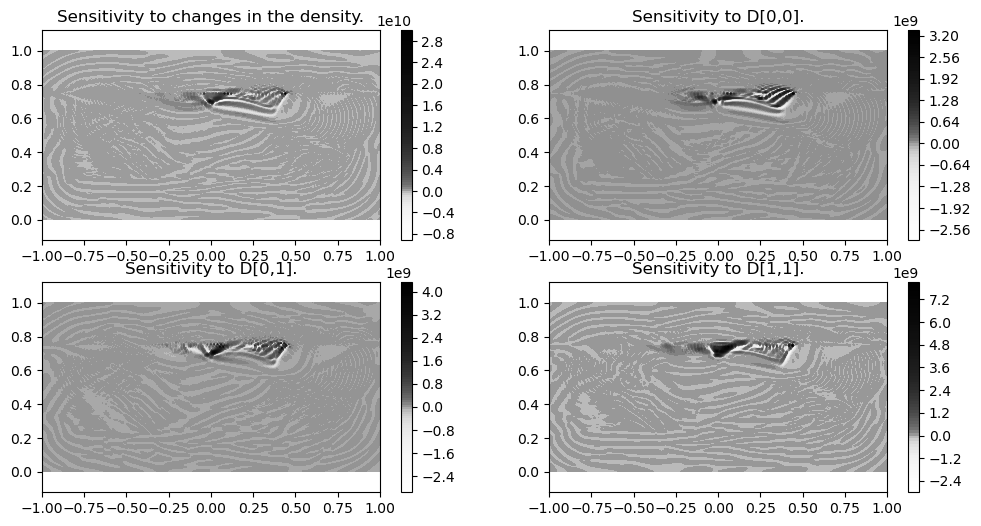

In [101]:
plt.figure(figsize=[12,6])

plt.subplot(2,2,1)
plt.title("Sensitivity to changes in the density.")
plt.contourf(*X,ρ_ξ[...,0],100,cmap='Greys',norm=AsinhNorm(linear_width = cupy_get(norm(ρ_ξ,averaged=True))))
plt.colorbar(); plt.axis('equal');

plt.subplot(2,2,2)
plt.title("Sensitivity to D[0,0].")
plt.contourf(*X,D_ξ[0,0,...,0],100,cmap='Greys',norm=AsinhNorm(linear_width = cupy_get(norm(D_ξ,averaged=True))))
plt.colorbar(); plt.axis('equal');

plt.subplot(2,2,3)
plt.title("Sensitivity to D[0,1].")
plt.contourf(*X,D_ξ[0,1,...,0],100,cmap='Greys',norm=AsinhNorm(linear_width = cupy_get(norm(D_ξ,averaged=True))))
plt.colorbar(); plt.axis('equal');

plt.subplot(2,2,4)
plt.title("Sensitivity to D[1,1].")
plt.contourf(*X,D_ξ[1,1,...,0],100,cmap='Greys',norm=AsinhNorm(linear_width = cupy_get(norm(D_ξ,averaged=True))))
plt.colorbar(); plt.axis('equal');

## 4. Elasticity

As far as this notebook is concerned, the structure of the elastic and the acoustic wave equations are very similar : 
- both are obtained as Hamilton's equations to quadratic hamiltonians
- both finite difference schemes use Voronoi's decomposition of positive quadratic forms
- both rely on absorbing boundary conditions

### 4.1 Homogeneous medium

<!---
def CFL_e(M,C,dx,**kwargs):
    """
    TODO : put this in the adequate classes.
    Largest time step guaranteed to be stable for the elastic wave equation
    kwargs : see CFL_mult
    """
    hooke = Hooke(C)
    tr = lp.trace(hooke.to_Mandel())
    M = np.moveaxis(M,(0,1),(-2,-1))
    iρ = np.max(np.linalg.eigvalsh(M),axis=-1)    
    return float(dx/(hooke.vdim*np.sqrt(np.max(iρ*tr)))) # * CFL_mult(**kwargs)
--->

In [102]:
dom,X,dx = make_domain(3,vdim=2)
M = xp.ones((1,1)) # Kinetic energy. Could use anisotropic matrix field, in case of coordinate changes.
C = mica.extract_xz().rotate_by(π/6).hooke
q0p = explosion(X) # pressure wave trigger
q0s = torsion(X) # Shear wave trigger
p0 = np.zeros_like(q0p)
bc = 'Neumann' if xp is np else 'Dirichlet' # Neumann is only implemented on CPU

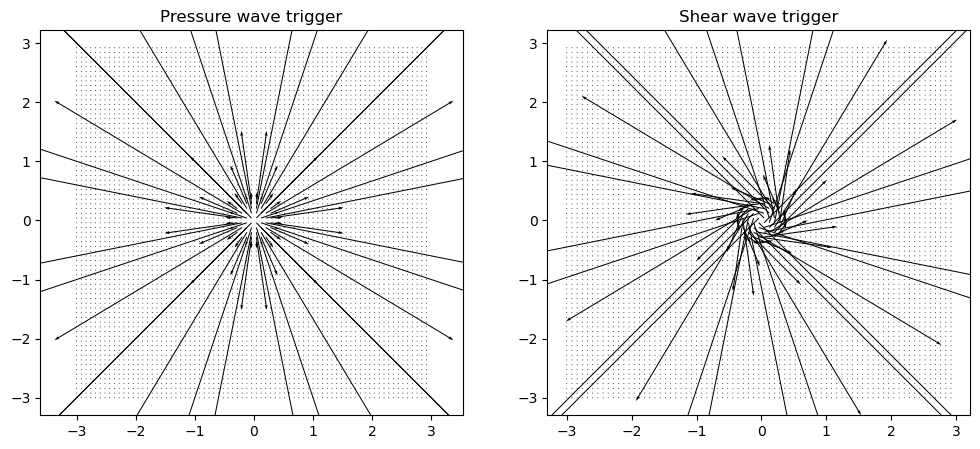

In [103]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.title("Pressure wave trigger")
quiver(*X,*q0p,subsampling=(2,2))
plt.axis('equal');
plt.subplot(1,2,2)
plt.title("Shear wave trigger")
quiver(*X,*q0s,subsampling=(2,2));

In [104]:
order_x=2; order_t=2

First, let us not use any damping.

In [105]:
H = ElasticHamiltonian(M,C,dx,shape_dom=dom.shape,order_x=order_x,bc=bc)

In [106]:
dt_max = H.dt_max(order_t)
dt = dt_max
niter=120

In [107]:
q1p,p1p = H.Sympl_p(q0p,p0,dt,niter,order=order_t)
q1s,p1s = H.Sympl_p(q0s,p0,dt,niter,order=order_t)

The pressure wave is faster (by definition), and has a simpler structure than the shear wave.

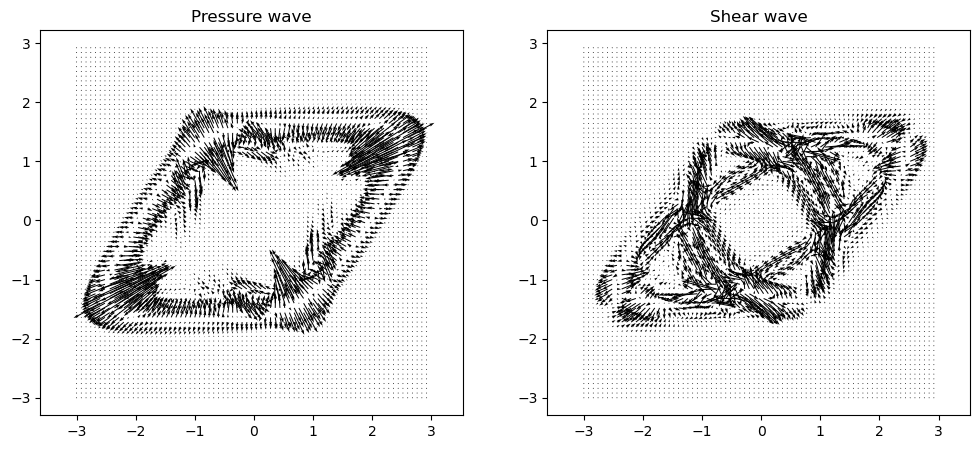

In [108]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1); plt.title("Pressure wave")
quiver(*X,*q1p,subsampling=(2,2)); plt.axis('equal')
plt.subplot(1,2,2); plt.title("Shear wave")
quiver(*X,*q1s,subsampling=(2,2)); plt.axis('equal');

Without damping, the energy defined by the perturbed Hamiltonian is conserved up to machine precision by the symplectic time integrator.

In [109]:
print(f"Initial/Final sqrt energy, pressure : {np.sqrt(H.H_p(q0p,p0,dt,order=2)/H.H_p(q1p,p1p,dt,order=2))}")
print(f"Initial/Final sqrt energy, shear : {np.sqrt(H.H_p(q0s,p0,dt,order=2)/H.H_p(q1s,p1s,dt,order=2))}")

Initial/Final sqrt energy, pressure : 1.0
Initial/Final sqrt energy, shear : 1.0


Let us add a damping layer on the boundary.

In [110]:
l = 0.5 # As seen from above
α = 2 # Typical, slightly thicker layer than for the acoustic case.
r = 500 # Desired reduction
c = 0.3*dx/dt_max # Wave speed heusitic

k = 2*π/l # Wave number
ω = c*k # Pulsation
l_damp = α*np.log(r)/k # Damping width
ω_damp = ω/α # Damping strength
damp_p = ω_damp * layer(l_damp,X)

In [111]:
niter=500
H.damp_p = damp_p
q1p,p1p = H.Sympl_p(q0p,p0,dt,niter,order=order_t)
q1s,p1s = H.Sympl_p(q0s,p0,dt,niter,order=order_t)

The pressure wave, whose front is thinner and simpler, is a bit more efficiently damped than the shear wave.

In [112]:
print(f"Initial/Final sqrt energy, pressure : {np.sqrt(H.H_p(q0p,p0,dt,order=2)/H.H_p(q1p,p1p,dt,order=2))}")
print(f"Initial/Final sqrt energy, shear : {np.sqrt(H.H_p(q0s,p0,dt,order=2)/H.H_p(q1s,p1s,dt,order=2))}")

Initial/Final sqrt energy, pressure : 288.97877953364434
Initial/Final sqrt energy, shear : 142.15587859182898


After damping, the pressure and shear wave have lost most of their structure. Incorrect parameter settings lead to more obvious reflections.

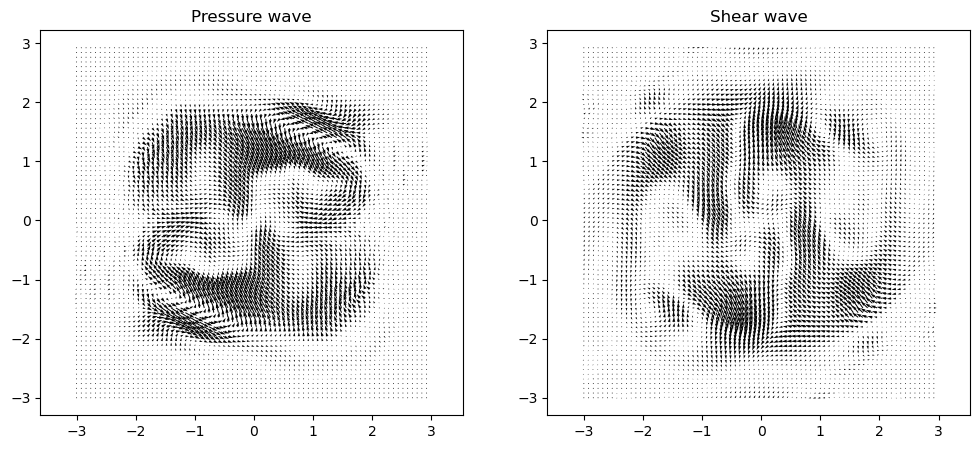

In [113]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1); plt.title("Pressure wave")
quiver(*X,*q1p,subsampling=(2,2)); plt.axis('equal')
plt.subplot(1,2,2); plt.title("Shear wave")
quiver(*X,*q1s,subsampling=(2,2)); plt.axis('equal');

### 4.2 Complex medium

Similarly to the acoustic case presented in section [2.2](#2.2-Complex-medium), we use the medium constructed in the first part of the notebook, equipped with Hooke tensors instead of diffusion tensors, and show how to extract seismograms. 

<!---
We use the classical BP 2007 TTI test case, but replace the TTI norm with an elliptic approximation. 
--->

In [114]:
nX = 150; dx = 1/nX
aX = xp.linspace(-1,1,2*nX+1,endpoint=True) # Horizontal axis
aZ = xp.linspace(0,1,nX+1,endpoint=True) # Vertical axis
X = xp.array(np.meshgrid(aX,aZ,indexing='ij')) # Full coordinate system
order_x=2; order_t=2;
bc='Neumann' if xp is np else 'Dirichlet'

σ = 2.5*dx # Approximate radius of initial impulsion
x0 = (0.,0.7)
q0p = explosion(X,σ,x0)
q0s = torsion(X,σ,x0)
p0 = np.zeros_like(q0p)
rec_height = 0.75 # We'll record the signal at this depth

In [115]:
inc_C = Hooke.from_Lame(1,1).with_speed(1/2).hooke

In [116]:
ρ,C = make_medium(X,layer_DC=layer_C,inc_DC=inc_C)
M = 1/ρ[None,None]

In [117]:
H = ElasticHamiltonian(M,C,dx,order_x=order_x,bc=bc)

In [118]:
dt_max = H.dt_max(order_t)
dt = dt_max

Without damping, the energy is exactly conserved by the symplectic scheme, similarly to the case of a constant medium.

In [119]:
niter=100
q1p,p1p = H.Sympl_p(q0p,p0,dt,niter,order_t)

In [120]:
assert np.allclose(H.H_p(q1p,p1p,dt,order_t),H.H_p(q0p,p0,dt,order_t))

We use a damping layer all around. Physically relevant boundary conditions, such as Neumann boundary conditions on part of the domain in the case of free surface, are not implemented presently. Recall also that the damping layer construction assumed constant coefficients, hence it could easily be improved.

In [121]:
H.damp_p = damping_layer(X,c=0.3*dx/dt_max,l=5*σ,α=2)

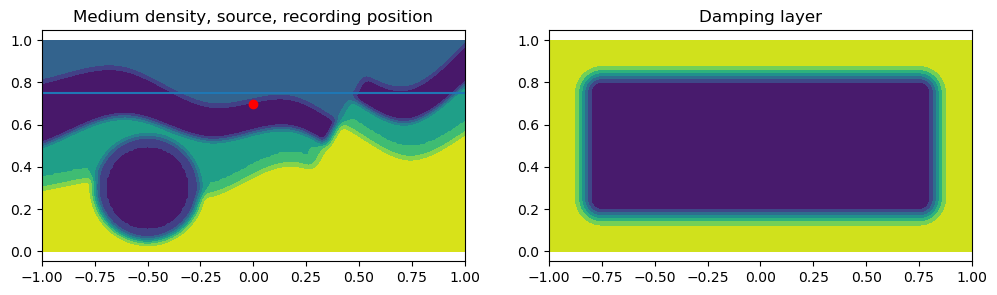

In [122]:
plt.figure(figsize=[12,3])
plt.subplot(1,2,1); plt.title("Medium density, source, recording position")
plt.contourf(*X,ρ)
plt.scatter(*x0,color='red'); plt.axhline(rec_height); plt.axis('equal');
plt.subplot(1,2,2); plt.title("Damping layer")
plt.contourf(*X,H.damp_p); plt.axis('equal');

In [123]:
niter = 400
q1p,p1p = H.Sympl_p(q0p,p0,dt,niter,order=order_t)
q1s,p1s = H.Sympl_p(q0s,p0,dt,niter,order=order_t)

We initially trigger almost pure pressure and shear waves, see above in the case of a constant medium. However, one can clearly in both cases a slow shear wave, and a fast pressure waves, which are generated through interactions with the medium.

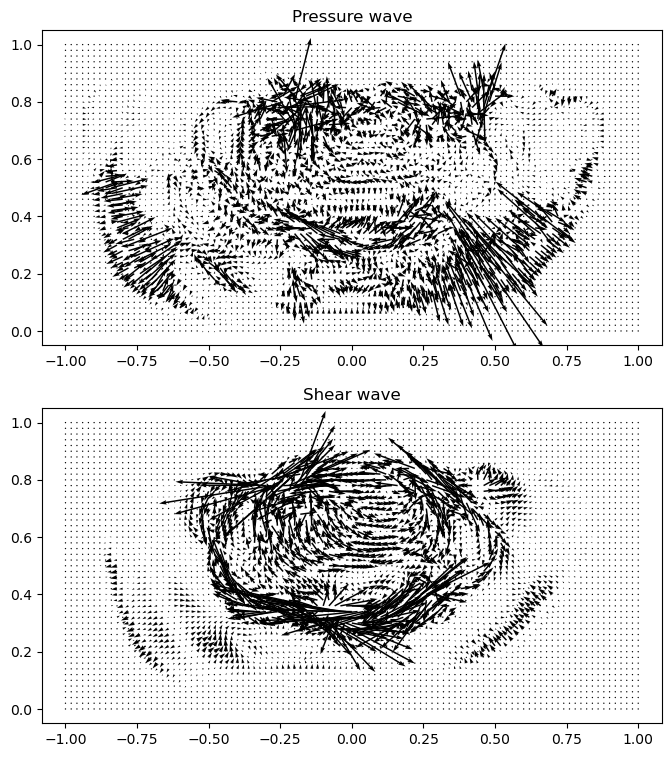

In [124]:
plt.figure(figsize=[8,9])
plt.subplot(2,1,1); plt.title("Pressure wave")
quiver(*X,*q1p,subsampling=3); plt.axis('equal')
plt.subplot(2,1,2); plt.title("Shear wave")
quiver(*X,*q1s,subsampling=3); plt.axis('equal');

Let us extract some seismogram data, at a given depth. 

In [125]:
rec_spacing = 0.02 # Horizontal spacing between two successive recordings
rec_q = []
q1,p1 = q0p,p0 # q0p is the pressure trigger. Try q0s for shear
niter=400
# See the discussion below of the reshape argument in the GPU case
damp_kwargs = {} if xp is np else {'reshape':True}
for i in range(niter):
    q1,p1 = H.Sympl_p(q1,p1,dt,order=order_t)
    rec_q.append(q1[:,::int(rec_spacing/dx),int(rec_height/dx)])
    q1,p1 = H.Damp_qp(q1,p1,dt,**damp_kwargs)
rec_q = ad.asarray(rec_q)

The seismogram that we extracted is vectorial : both the horizontal and the vertical of $q_0$ are recorded. 

In [126]:
rec_q.shape

(400, 2, 101)

We display the seismogram using the `Asinh` scale, which is linear near the zero, and logarithmic for large values.

Note that we clearly see the effect of the reflection on the right, left and top boundaries. There is clearly some room for improvement in the tuning of the absorbing boundary conditions.

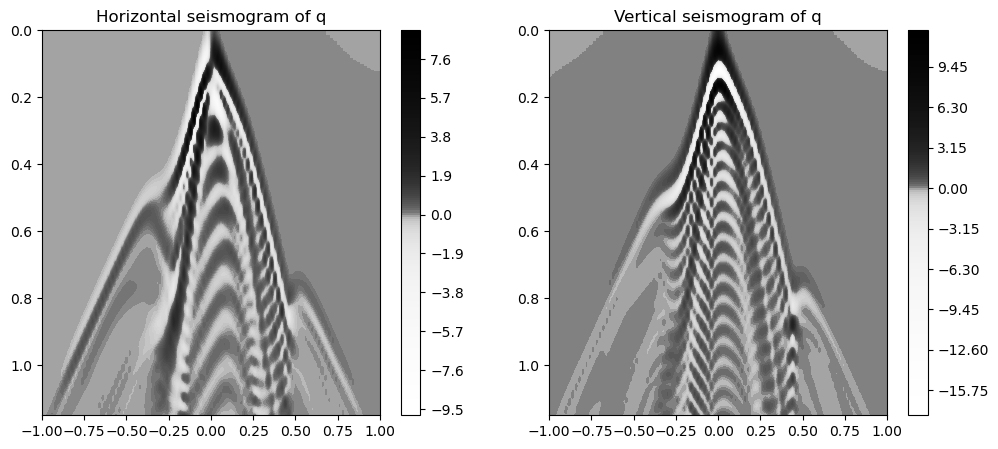

In [127]:
rec_T = xp.arange(niter)*dt
rec_X = xp.linspace(-1,1,len(rec_q[0,0]))
plt.figure(figsize=[12,5])
for i,(orient,rec_qi) in enumerate(zip(("Horizontal","Vertical"),np.moveaxis(rec_q,1,0))):
    plt.subplot(1,2,1+i)
    plt.title(f"{orient} seismogram of q")
    plt.contourf(rec_X,rec_T,rec_qi,levels=200,cmap='Greys',norm=AsinhNorm(linear_width = 0.1))
    plt.gca().invert_yaxis(); plt.colorbar();

**'reshape' argument in Damp_qp.**
The GPU kernel implementation of the elastic wave Hamiltonian uses a special memory layout of the unknowns, intended so that CPU threads of a common block of threads access contiguous data as often as possible.

In [128]:
if xp is not np: 
    print(f"Basic shape {q0p.shape}, GPU friendly shape {H.reshape(q0p).shape}")

For that reason, the high-level functions (Sympl_p, seismogram, ...) reshape and pad their arguments as a pre-processing step, and perform the reversed operation as a post-processing step.

However performing these reshaping operations too often defeats the purpose of the optimized memory layout, and for this reason they are not implemented or off by default in the case of elementary operations (Damp_qp, Expl_p, ...), which .

**'seismogram' method.**
Similarly to the acoustic case, we can use the seismogram method to extract the same data. This approach is a more efficient numerically, on the GPU at least, because the reshaping described above is only done at the beginning and the end, as intended, rather than at each substep.

In [129]:
q_range = xp.arange(q0p.size).reshape(q0p.shape)
qh_ind = np.unravel_index(q_range[:,::int(rec_spacing/dx),int(rec_height/dx)],q_range.shape)

In [130]:
qf,pf,qh,ph = H.seismogram(q0p,p0,dt,niter,order_t,qh_ind=qh_ind)

In [131]:
if xp is np:
    assert np.allclose(qh,rec_q[:-1])
    assert np.allclose(qf[*qh_ind],rec_q[-1])
else:
    assert np.allclose(qh,rec_q[:-1],atol=norm(qh,np.inf)*1e-5)
    assert np.allclose(qf[*qh_ind],rec_q[-1],atol=norm(rec_q[-1])*1e-5)

### 4.3 Forward differentiation

Similarly to the acoustic case [2.3](#2.3-Forward-differentiation), we illustrate forward differentiation of the elastic wave equation w.r.t the medium.

In [132]:
# Three independent symbolic perturbations
δ_ad = ad.Dense.identity(constant=xp.zeros(4))

# Symbolic perturbation of the topographic change of variables
topo_heights_ad = ad.Dense.denseAD(topo_heights)
topo_heights_ad[3] += δ_ad[0]

# Symbolic perturbation of the vertical position of the inclusion
inc_center_ad = ad.Dense.denseAD(inc_center)
inc_center_ad[1] += δ_ad[1]

# Symbolic perturbation of the fault position
shift_origin_ad = ad.Dense.denseAD(shift_origin)
shift_origin_ad[0] += δ_ad[2]

# Symbolic perturbation of the orientation of the anisotropy
layer_C_ad = ad.Dense.denseAD(layer_C)
layer_C_ad[2] = Hooke(layer_C_ad[2]).rotate_by(-δ_ad[3]).hooke

In [133]:
ρ_ad,C_ad = make_medium(X,topo_heights=topo_heights_ad,inc_center=inc_center_ad,
                        shift_origin=shift_origin_ad,layer_DC=layer_C_ad,inc_DC=inc_C)

Note that the latest symbolic perturbation mainly affects the off-diagonal coefficients of the dual-metric $C$. 
This is really a non-isotropic and non-vti effect.

<!---
test = ad.Dense.denseAD(np.array([1.,2.]))
test.reshape(-1)
test = ad.Sparse.spAD(np.array([1.,2.]))
test.reshape(-1)
test = ad.Dense2.denseAD2(np.array([1.,2.]))
test.reshape(-1)
test = ad.Sparse2.spAD2(np.array([1.,2.]))
test.reshape(-1)
--->

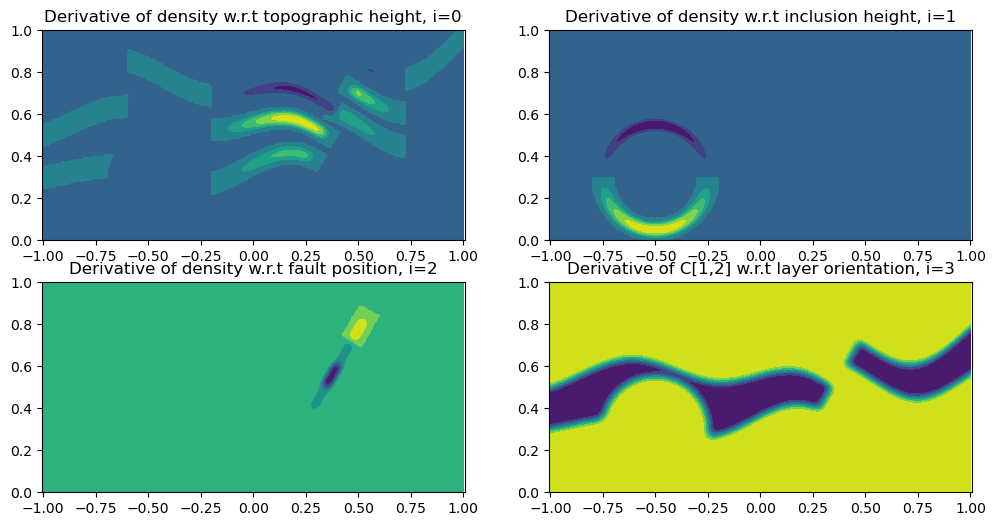

In [134]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1); plt.title("Derivative of density w.r.t topographic height, i=0")
plt.contourf(*X,ρ_ad.gradient(0)); plt.axis('equal')
plt.subplot(2,2,2); plt.title("Derivative of density w.r.t inclusion height, i=1")
plt.contourf(*X,ρ_ad.gradient(1)); plt.axis('equal')
plt.subplot(2,2,3); plt.title("Derivative of density w.r.t fault position, i=2")
plt.contourf(*X,ρ_ad.gradient(2)); plt.axis('equal')
plt.subplot(2,2,4); plt.title("Derivative of C[1,2] w.r.t layer orientation, i=3")
plt.contourf(*X,C_ad[1,2].gradient(3)); plt.axis('equal');

The following cells are a bit long to execute on the CPU.

In [135]:
M_ad = 1/ρ_ad[None,None]
H_ad = ElasticHamiltonian(M_ad,C_ad,dx,order_x=order_x,bc=bc)

In [136]:
H_ad.damp_p = H.damp_p

In [137]:
q0p_ad,p0_ad = ad.Dense.denseAD(q0p),ad.Dense.denseAD(p0)
niter = 300
q1,p1 = H_ad.Sympl_p(q0p_ad,p0_ad,dt,niter,order_t)

We differentiate the solution w.r.t each of the four considered symbolic perturbations of the medium. 
Note that the obtained symbolic perturbation of the solution has a wide support, because these perturbations propagate, are reflected, etc.

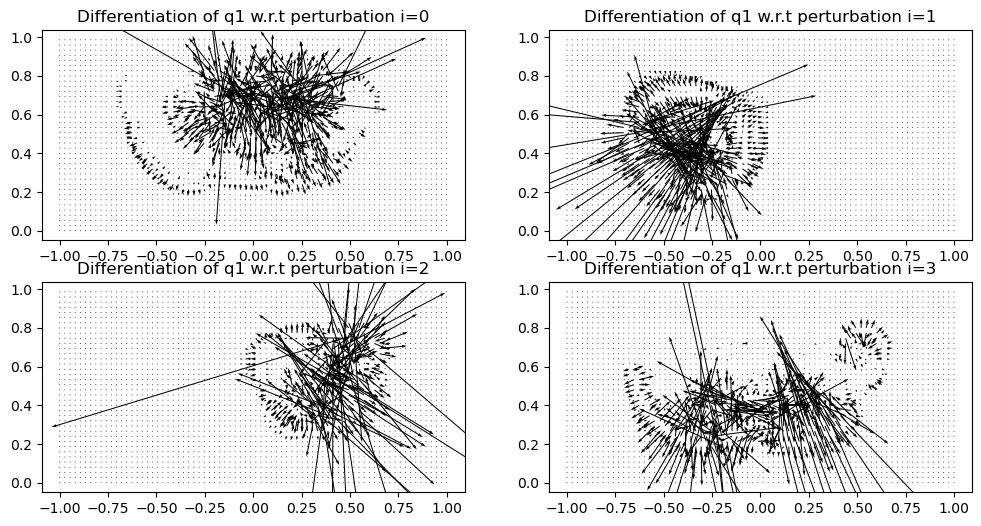

In [138]:
plt.figure(figsize=[12,6])
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(f"Differentiation of q1 w.r.t perturbation {i=}")
    quiver(*X,*q1.gradient(i),subsampling=4)
    plt.axis('equal')

In [139]:
rec_q_ad = []
q1,p1 = q0p_ad,p0_ad
niter=400
for i in range(niter):
    q1,p1 = H_ad.Sympl_p(q1,p1,dt,order=order_t)
    rec_q_ad.append(q1[:,::int(rec_spacing/dx),int(rec_height/dx)])    
    q1,p1 = H_ad.Damp_qp(q1,p1,dt,**damp_kwargs)
rec_q_ad = ad.asarray(rec_q_ad)

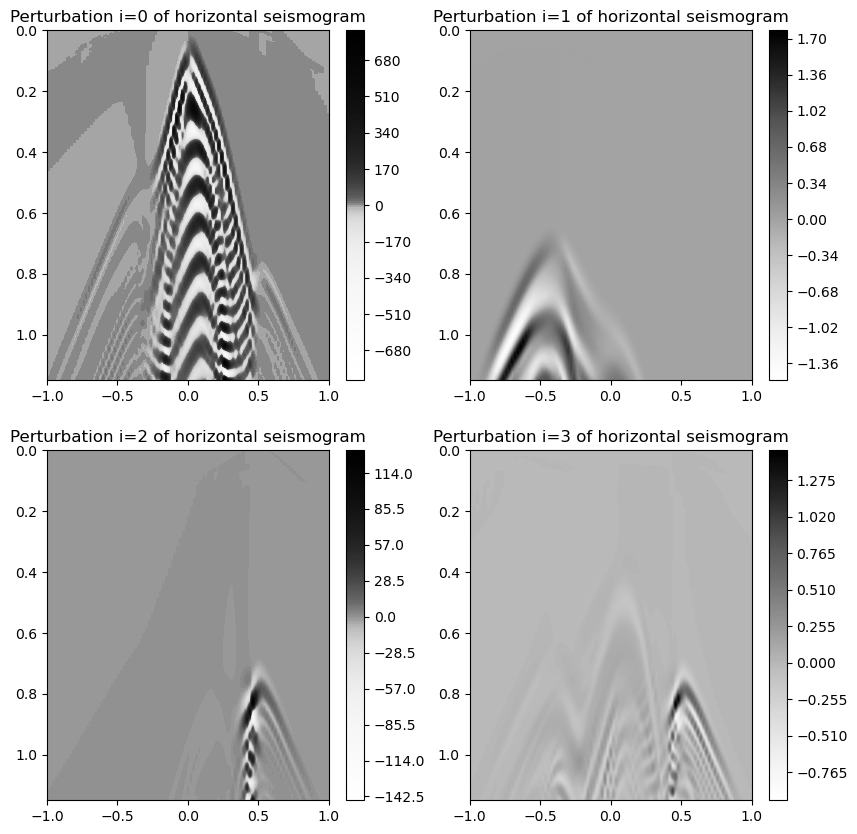

In [140]:
plt.figure(figsize=[10,10])
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(f"Perturbation {i=} of horizontal seismogram")
    plt.contourf(rec_X,rec_T,rec_q_ad.gradient(i)[:,0],levels=200,cmap='Greys',norm=AsinhNorm(linear_width = 10))
    plt.gca().invert_yaxis()
    plt.colorbar();

**'seismogram' method.**
Similar to the case without AD.

In [141]:
qf,pf,qh,ph = H_ad.seismogram(q0p_ad,p0_ad,dt,niter,order_t,qh_ind=qh_ind)

In [142]:
if xp is np:
    assert np.allclose(qh,rec_q_ad[:-1])
    assert np.allclose(qf[*qh_ind],rec_q_ad[-1])
else:
    assert np.allclose(qh.value,rec_q_ad[:-1].value,atol=norm(qh.value,np.inf)*1e-5)
    assert np.allclose(qf[*qh_ind].value,rec_q_ad[-1].value,atol=norm(rec_q_ad[-1].value)*1e-5)
    assert np.allclose(qh.coef,rec_q_ad[:-1].coef,atol=norm(qh.coef,np.inf)*1e-5)
    assert np.allclose(qf[*qh_ind].coef,rec_q_ad[-1].coef,atol=norm(rec_q_ad[-1].coef)*1e-5)

### 4.4 Reverse differentiation

Reverse differentiation proceeds exactly as for the forward case. Since this notebook is already quite big, and long to execute, we do not illustrate it here. Nevertheless, we validate it on some tiny test cases in the preliminary section, see the `check_ad` function, which can easily be extended to larger instances.